In [1]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py
import pandas as pd

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
import gala.coordinates as gc
from gala.units import galactic
import yaml
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [2]:
def lons_lats(pos, vel):
    prog = gd.PhaseSpacePosition(pos[0] * u.kpc, vel[0] * u.km / u.s)
    stream = gd.PhaseSpacePosition(pos[1:].T * u.kpc, vel[1:].T * u.km / u.s)
    R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
    R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
    R_prog0 = R2.as_matrix() @ R1.as_matrix()  

    new_vxyz = R_prog0 @ prog.v_xyz
    v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
    R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
    R = (R3 * R2 * R1).as_matrix()

    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    stream_sph = stream_rot.spherical
    lon = stream_sph.lon.wrap_at(180*u.deg).degree
    lat = stream_sph.lat.degree
    return lon, lat

In [3]:
def energies_vec(t, xs, vs, mwdflag, mwhflag, lmcflag, motion):
    """
    calculate the energies and angular momenta of particles for a given time snapshot.
    In the Galactocentric coordinate system. 
    xs,vs are already in GC coords.
    """
    # Kinetic energy
    Ek = (.5 * np.linalg.norm(vs, axis=1)**2) * (u.km/u.s)**2
    # Potential energy
    x0 = np.array(Model.expansion_centres(t))

    if motion == False:
        x0 *= 0 
    
    x_lmc_GC = x0[6:9] - x0[:3]
            
    pot_disk = Model.mwd_fields(t,  xs[:,0], xs[:,1], xs[:,2], mwdflag)[:,4]
    pot_halo = Model.mwhalo_fields(t, xs[:,0], xs[:,1], xs[:,2], mwhflag)[:,4]
    pot_lmc = Model.lmc_fields(t, 
                               xs[:,0] - x_lmc_GC[0],
                               xs[:,1] - x_lmc_GC[1],
                               xs[:,2] - x_lmc_GC[2],
                               lmcflag)[:,4]
    Ep = (pot_disk + pot_halo + pot_lmc) * (u.km/u.s)**2
    E = Ek + Ep
    return E

Visualising in stream coordinates

In [4]:
def stream_frame_comp(path, plotname, savefig=False):
    
    # folders = list(['stream1','stream15', 'stream39', 'stream53', 'stream106'])
    folders = list(['stream15', 'stream53', 'stream106'])
    
    dts = list(['dt_2myr.hdf5', 'dt_1myr.hdf5', 'dt_halfmyr.hdf5', 'dt_tenthmyr.hdf5']) 
    titles = list([r'$\mathrm{dt} = 2\,\mathrm{Myr}$', r'$\mathrm{dt} = 1\,\mathrm{Myr}$', 
                   r'$\mathrm{dt} = 0.5\,\mathrm{Myr}$', r'$\mathrm{dt} = 0.1\,\mathrm{Myr}$'])
    t_idx = -1
    
    fig, ax = plt.subplots(len(folders), len(dts), sharex='col', sharey='row', figsize=(12,6))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(folders)): 
        for j in range(len(dts)):   
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / folders[i] / dts[j]
            with h5py.File(data_path,'r') as file:
                prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
                stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
                start_times = np.array(file['times'])
                prog_mass = np.array(file['progenitor-mass']) * u.Msun
            #-------------------------------------------------------------------------------------
            ### Rotation matrix for progenitor to get it to near (X, 0, 0)
            #-------------------------------------------------------------------------------------
            R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
            R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
            R_prog0 = R2.as_matrix() @ R1.as_matrix()  
            #-------------------------------------------------------------------------------------
            ### Rotate around new x axis so stream prog vel points along +y direction
            #-------------------------------------------------------------------------------------
            new_vxyz = R_prog0 @ prog.v_xyz
            v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
            R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
            R = (R3 * R2 * R1).as_matrix()
            #-------------------------------------------------------------------------------------
            ### Rotate the whole stream by the final rotation matrix
            #-------------------------------------------------------------------------------------
            prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
            prog_sph = prog_rot.spherical
            stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
            stream_sph = stream_rot.spherical
            lon = stream_sph.lon.wrap_at(180*u.deg).degree
            lat = stream_sph.lat.degree
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7, zorder=1)
            plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7, zorder=1)
            plot=plt.scatter(lon, lat, s=.5, c='k', alpha=.1, rasterized=True)
            
            if j==0:
                plt.annotate(text='{}'.format(folders[i]), xy=(-180,65), fontsize=8, color='red' )
                plt.annotate(text=r'M = {} $\times \, 10^{{4}} \, \mathrm{{M}}_{{\odot}}$'.format(np.round(prog_mass.value/1e4, 1)),
                             xy=(-180, -80), fontsize=8)
        
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    for k in range(len(titles)):
        ax[0,k].set_title(titles[k])
        ax[-1,k].set_xlabel(r'$\mathrm{lon}\,[^{\circ}]$')
        ax[-1,k].set_xlim(-199,199)
        
    for l in range(len(folders)):
        ax[l, 0].set_ylabel(r'$\mathrm{lat}\,[^{\circ}]$')
        ax[l, 0].set_ylim(-99,99)

    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

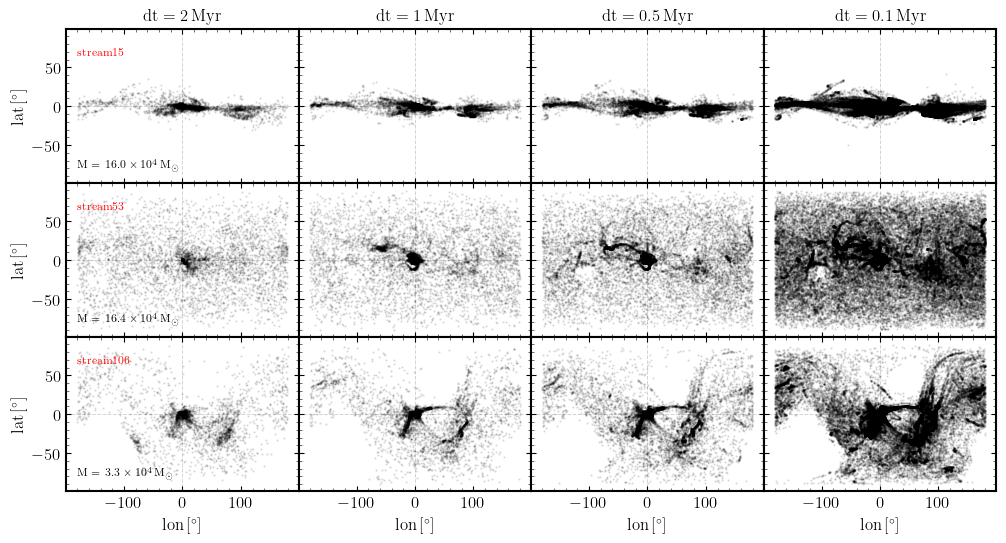

In [5]:
data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/high-vel-dis/" 

stream_frame_comp(data_path, 'dt-stream-frame-comp', False)

dt size vs local velocity dispersion 

In [6]:
def stream_veldis_comp(path, plotname, savefig=False):
    
    # folders = list(['stream1','stream15', 'stream39', 'stream53', 'stream106'])
    folders = list(['stream15', 'stream53', 'stream106'])
    

    dts = list(['dt_2myr.hdf5', 'dt_1myr.hdf5', 'dt_halfmyr.hdf5', 'dt_tenthmyr.hdf5']) 
    titles = list([r'$\mathrm{dt} = 2\,\mathrm{Myr}$', r'$\mathrm{dt} = 1\,\mathrm{Myr}$', 
                   r'$\mathrm{dt} = 0.5\,\mathrm{Myr}$', r'$\mathrm{dt} = 0.1\,\mathrm{Myr}$'])
    dts_points = np.array([2, 1, 0.5, 0.1])

    fig, ax = plt.subplots(1,1, sharex='col', sharey='row', figsize=(5,3))
    
    for i in range(len(folders)): 
        veldis = []
        for j in range(len(dts)):   
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / folders[i] / dts[j]
            with h5py.File(data_path,'r') as file:
                loc_veldis = np.array(file['loc_veldis'])
            veldis.append(loc_veldis)
        plt.plot(dts_points, veldis, marker='o', markersize=3,label = folders[i])
    
    plt.xlabel('dt [Myr]')
    plt.ylabel(r'$\sigma_{v,\,\mathrm{loc}}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
    plt.xlim(0.001,2.1)
    plt.ylim(0.1,120)
    plt.legend(frameon=False, fontsize=10, ncol=3)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

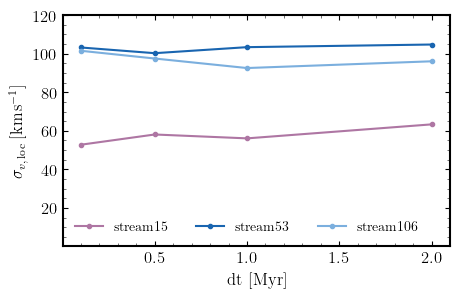

In [7]:
stream_veldis_comp(data_path, 'dt-stream-veldis-comp', False)

time vs closest particle to disc 

In [8]:
def disc_stream_sep(path, plotname, dt, savefig=False):
    
    folders = list(['stream1','stream15', 'stream39', 'stream53', 'stream106'])
    # folders = list(['stream15', 'stream53', 'stream106'])
    fig, ax = plt.subplots(1,1, sharex='col', sharey='row', figsize=(6,3))
    
    if dt=='halfMyr':
        divison, end = 500, 'dt_halfmyr.hdf5'
        
    if dt=='2Myr':
        divison, end = 250, 'dt_2myr.hdf5'
        
    if dt=='tenthMyr':
        divison, end = 500, 'dt_tenthmyr.hdf5'
    
    for i in range(len(folders)): 
         
        data_path = pathlib.Path(path) / folders[i] / end
        with h5py.File(data_path,'r') as file:
            positions = np.array(file["positions"])
            ts =  np.array(file["times"])[2::2]

        ts_snaps = np.flip(np.flip(ts, axis=0)[::divison])
        disc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[9:12]) for t in ts_snaps])

        stream_rs = np.linalg.norm(positions, axis=2)
        min_disc_stream_sep = np.nanmin(stream_rs, axis=1)
        # min_disc_prog_sep = stream_rs[:,0]
        plt.plot(ts_snaps, min_disc_stream_sep, marker='o', markersize=3, label = folders[i])
        # plt.plot(ts_snaps, stream_rs[:,0], marker='o', markersize=1, label = folders[i])
    # plt.plot(ts_snaps, disc_rs, label='disc')
    
    plt.xlabel('Lookback time [Gyr]')
    plt.ylabel(r'$\mathbf{r}_{\mathrm{sep,\,min}}\,[\mathrm{kpc}]$')
    # plt.ylabel(r'$\mathbf{r}(t)\,[\mathrm{kpc}]$')
    plt.xlim(-5, 0.)
    # plt.ylim(0.,30)
    plt.legend(frameon=False, fontsize=10, ncol=3)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/{}'.format(plotname + '_' + dt) )

Cannot select a time after the present day! Setting to present day...
Cannot select a time after the present day! Setting to present day...
Cannot select a time after the present day! Setting to present day...
Cannot select a time after the present day! Setting to present day...
Cannot select a time after the present day! Setting to present day...


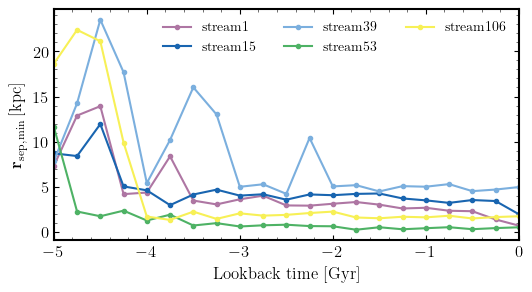

In [9]:
data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/high-vel-dis/" 
disc_stream_sep(data_path, 'disc_stream_sep', 'halfMyr', False)

In [10]:
def exp_centers(ts, plotname, savefig=False):

    plt.figure(figsize=(5,3))

    disc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[9:12]) for t in ts ])
    halo_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[3:6]) for t in ts ])
    lmc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[6:9]) for t in ts ])
    plt.plot(ts, disc_rs, label='Disc')
    plt.plot(ts, halo_rs, label='Halo')
    plt.plot(ts, lmc_rs, label='LMC')
    
    plt.xlabel('Lookback time [Gyr]')
    plt.ylabel(r'$\mathbf{r}_{\mathrm{exp,\,center}}\,[\mathrm{kpc}]$')
    plt.xlim(-5, 0.)
    plt.ylim(-1, 75)
    plt.legend(frameon=False, fontsize=10)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/{}'.format(plotname) )

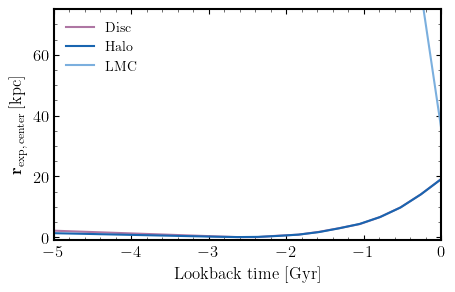

In [11]:
exp_centers(np.linspace(-5,0,20), 'exp-centers', False)

In [12]:
def disc_displacement_motion(ts, plotname, savefig=False):

    fig,ax = plt.subplots(1, 2, figsize=(10,3))

    colors = ['b', 'g', 'r']

    plt.subplots_adjust(wspace=0.3)

    disc_rs = np.array([Model.expansion_centres(t)[9:12] for t in ts ])
    disc_vs = np.array([Model.expansion_centre_velocities(t)[9:12] for t in ts ])
    plt.sca(ax[0])
    for i, label in enumerate(['x', 'y', 'z']):
        plt.plot(ts, disc_rs[:, i], label=label, color=colors[i])
    
    plt.xlabel('Lookback time [Gyr]')
    plt.ylabel(r'$x_{\mathrm{i,\,disc}}\,[\mathrm{kpc}]$')
    plt.xlim(-2, 0.)
    plt.ylim(-15, 45)
    plt.legend(frameon=False, fontsize=10)

    plt.sca(ax[1])
    # plt.plot(ts, disc_vs, label=['vx', 'vy', 'vz'])
    for i, label in enumerate(['vx', 'vy', 'vz']):
        plt.plot(ts, disc_vs[:, i], label=label, color=colors[i])
    
    plt.xlabel('Lookback time [Gyr]')
    plt.ylabel(r'$v_{\mathrm{i,\,disc}}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
    plt.xlim(-2, 0.)
    plt.ylim(-60, 60)
    plt.legend(frameon=False, fontsize=10)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/{}'.format(plotname) )

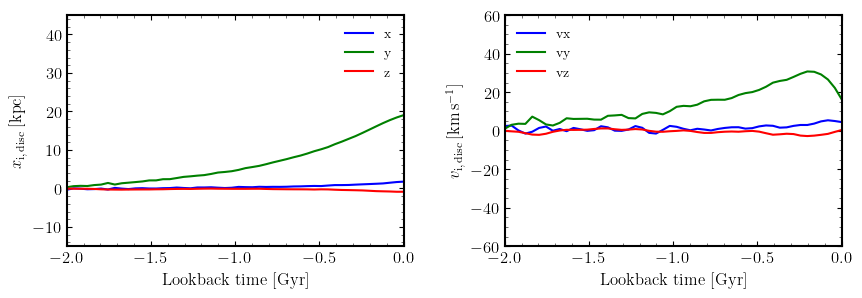

In [13]:
disc_displacement_motion(np.linspace(-2,0,50), 'disc-displacement-motions', False)

       t         x        y       z       vx       vy       vz
400  0.0 -0.561918 -40.7118 -27.177 -63.9522 -214.517  206.584
[ -1.69233909 -40.8985785  -27.27435555]
[ -52.13949543 -367.25498914  295.31041188]


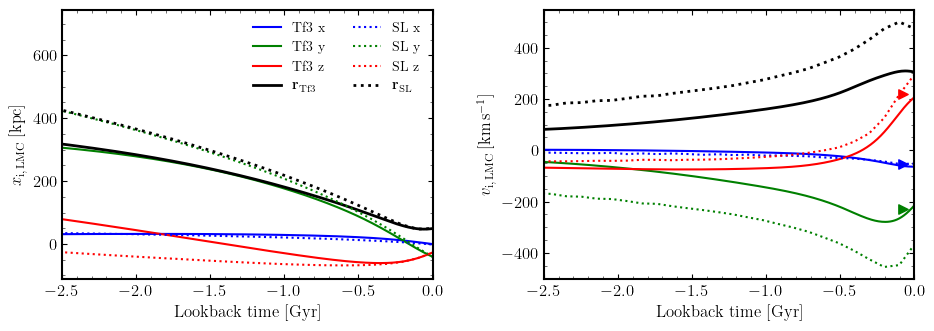

In [14]:
import pandas as pd

def lmc_orbits(ts, plotname, savefig):

    fig,ax = plt.subplots(1, 2, figsize=(11,3.5))


    plt.subplots_adjust(wspace=0.3)

    plt.sca(ax[0])
    lmctraj_tf3 = pd.read_csv('../analysis/potentials_triax/trajlmc.txt', sep=' ',
               header=None, names=['t', 'x', 'y','z','vx','vy','vz'],)
    print(lmctraj_tf3[lmctraj_tf3.t == 0])
    
    plt.plot(lmctraj_tf3.t, lmctraj_tf3.x, color='b', label='Tf3 x')
    plt.plot(lmctraj_tf3.t, lmctraj_tf3.y, color='g', label='Tf3 y')
    plt.plot(lmctraj_tf3.t, lmctraj_tf3.z, color='r', label='Tf3 z')
    lmc_rs = (lmctraj_tf3.x**2 + lmctraj_tf3.y**2 + lmctraj_tf3.z**2)**.5
    plt.plot(lmctraj_tf3.t, lmc_rs, c='k', lw=2, label=r'$\mathbf{r}_\mathrm{Tf3}$')

    
    lmc_sl = np.array([Model.expansion_centres(t)[6:9] for t in ts ])
    disc_sl = np.array([Model.expansion_centres(t)[9:12] for t in ts ])
    print((lmc_sl - disc_sl)[-1])
    colors = ['b', 'g', 'r']

    for i, label in enumerate(['SL x', 'SL y', 'SL z']):
        plt.plot(ts, lmc_sl[:, i] - disc_sl[:,i], label=label, color=colors[i], ls='dotted')
    plt.plot(ts, np.linalg.norm(lmc_sl - disc_sl, axis=1), label=r'$\mathbf{r}_\mathrm{SL}$', c='k', lw=2, ls='dotted')
    plt.legend(frameon=False, fontsize=10, ncol=2)

    plt.xlabel('Lookback time [Gyr]')
    plt.ylabel(r'$x_{\mathrm{i,\,LMC}}\,[\mathrm{kpc}]$')

    plt.xlim(-2.5,0)

    plt.sca(ax[1])

    plt.plot(lmctraj_tf3.t, lmctraj_tf3.vx, color='b', label='Tf3 vx')
    plt.plot(lmctraj_tf3.t, lmctraj_tf3.vy, color='g', label='Tf3 vy')
    plt.plot(lmctraj_tf3.t, lmctraj_tf3.vz, color='r', label='Tf3 vz')
    lmc_vs = (lmctraj_tf3.vx**2 + lmctraj_tf3.vy**2 + lmctraj_tf3.vz**2)**.5
    plt.plot(lmctraj_tf3.t, lmc_vs, c='k', lw=2, label=r'$\mathbf{v}_\mathrm{Tf3}$')

    
    lmc_sl = np.array([Model.expansion_centre_velocities(t)[6:9] for t in ts ])
    disc_sl = np.array([Model.expansion_centre_velocities(t)[9:12] for t in ts ])
    print((lmc_sl - disc_sl)[-1])
    colors = ['b', 'g', 'r']

    for i, label in enumerate(['SL vx', 'SL vy', 'SL vz']):
        plt.plot(ts, lmc_sl[:, i] - disc_sl[:, i], label=label, color=colors[i], ls='dotted')
    plt.plot(ts, np.linalg.norm(lmc_sl - disc_sl, axis=1), label=r'$\mathbf{v}_\mathrm{SL}$', c='k', lw=2, ls='dotted')

    plt.scatter(-0.08, -54, c='b', marker='>', s=45)
    plt.scatter(-0.08, -228.5, c='g', marker='>', s=45)
    plt.scatter(-0.08, 217.6, c='r', marker='>', s=45)
    
    # plt.legend(frameon=False, fontsize=10, ncol=2)

    plt.xlim(-2.5,0)

    plt.xlabel('Lookback time [Gyr]')
    plt.ylabel(r'$v_{\mathrm{i,\,LMC}}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')

    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/{}'.format(plotname) )

lmc_orbits(np.linspace(-5,0,50), 'LMC-displacement-motions', False)

In [15]:
lmc_icrs_sl = SkyCoord(ra=78.76*u.deg,
                   dec=-69.19*u.deg,
                   distance=49.59*u.kpc,
                   pm_ra_cosdec=1.91*u.mas/u.yr,
                   pm_dec=0.229*u.mas/u.yr,
                   radial_velocity=262.2*u.km/u.s, galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)

lmc_icrs_tf3 = SkyCoord(ra=81*u.deg,
                   dec=-69.75*u.deg,
                   distance=50*u.kpc,
                   pm_ra_cosdec=1.8*u.mas/u.yr,
                   pm_dec=0.35*u.mas/u.yr,
                   radial_velocity=260*u.km/u.s, galcen_distance=8.12*u.kpc, galcen_v_sun=(12.9, 245.6, 7.8)*u.km/u.s )


In [16]:
lmc_icrs_sl.transform_to('galactocentric')

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
    (-1.04575158, -40.61609798, -27.53691708)
 (v_x, v_y, v_z) in km / s
    (-53.95335746, -228.50673105, 217.55057855)>

In [17]:
lmc_icrs_tf3.transform_to('galactocentric')

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
    (-0.57300557, -41.30628971, -27.12332489)
 (v_x, v_y, v_z) in km / s
    (-63.85012797, -213.82522483, 206.63581922)>

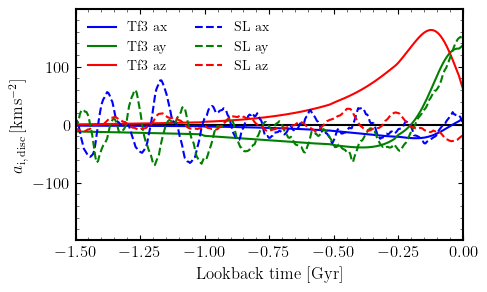

In [18]:
def disc_accel(ts, plotname, savefig=False):

    fig,ax = plt.subplots(1, 1, figsize=(5,3))
    colors = ['b', 'g', 'r']
    plt.subplots_adjust(wspace=0.3)

    comacc_tf3 = pd.read_csv('../analysis/potentials_triax/accel.txt', sep=' ',
           header=None, names=['t', 'ax','ay','az'],)

    plt.hlines(0,-5,0, color='k')

    plt.plot(comacc_tf3.t, comacc_tf3.ax, color='b', label='Tf3 ax')
    plt.plot(comacc_tf3.t, comacc_tf3.ay, color='g', label='Tf3 ay')
    plt.plot(comacc_tf3.t, comacc_tf3.az, color='r', label='Tf3 az')

    disc_vs = np.array([Model.expansion_centre_velocities(t)[9:12] for t in ts ])
    disc_as = -np.diff(disc_vs, axis=0)/np.median(np.diff(ts))

    for i, label in enumerate(['SL ax', 'SL ay', 'SL az']):
        plt.plot(ts[1:], disc_as[:, i], label=label, color=colors[i], ls='dashed')
    
    plt.xlabel('Lookback time [Gyr]')
    plt.ylabel(r'$a_{\mathrm{i,\,disc}}\,[\mathrm{km}\,\mathrm{s}^{-2}]$')
    plt.xlim(-1.5, 0.)
    plt.ylim(-199, 199)
    plt.legend(frameon=False, fontsize=10, ncol=2)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/{}'.format(plotname) )
disc_accel(np.linspace(-2.5,0, 500), 'com-accs', False)

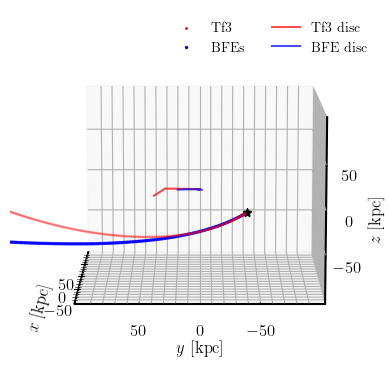

In [24]:
import matplotlib.animation as animation
import matplotlib.patches as patches

azims = np.linspace(-180, 180, 100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def lmc_paths_rot(frame):
    ax.clear()

    ts = np.linspace(-5,0,1000)

    # Plotting how the LMC has moved in each simulation...
    lmctraj_tf3 = pd.read_csv('../analysis/potentials_triax/trajlmc.txt', sep=' ',
                   header=None, names=['t', 'x', 'y','z','vx','vy','vz'],)
    
    ax.scatter(lmctraj_tf3.x[:400], lmctraj_tf3.y[:400], lmctraj_tf3.z[:400], c='r', s=2, zorder=1, label='Tf3')
    ax.scatter(lmctraj_tf3.x[400], lmctraj_tf3.y[400], lmctraj_tf3.z[400],
               c='k', marker='*', s=30, zorder=2)
    
    lmc_sl = np.array([Model.expansion_centres(t)[6:9] for t in ts ])
    disc_sl = np.array([Model.expansion_centres(t)[:3] for t in ts ])
    ax.scatter(lmc_sl[:,0] - disc_sl[:,0], 
               lmc_sl[:,1]- disc_sl[:,1], 
               lmc_sl[:,2]- disc_sl[:,2], c='b', s=2, zorder=1, label='BFEs')
    ax.scatter(lmc_sl[:,0][-1] - disc_sl[:,0][-1], 
               lmc_sl[:,1][-1] - disc_sl[:,1][-1], 
               lmc_sl[:,2][-1] - disc_sl[:,2][-1], c='k', marker='*', s=30, zorder=2)

    # Plotting how the disc has moved in each simulation...
    
    # Tf3
    # Approximate displacement (in kpc) based on visual estimation
    # y-displacement (green curve)
    y_displacement = np.linspace(0, 40, 200)
    # x-displacement (blue curve)
    x_displacement = np.linspace(0, 10, 200)
    # z-displacement (red curve)
    z_displacement = np.concatenate([
        np.linspace(0, -1, 150),  # First part (slow decrease)
        np.linspace(-1, -10, 50) # Second part (faster drop)
    ])
    ax.plot(x_displacement, y_displacement, z_displacement, color='r', alpha=0.7, label='Tf3 disc')

    # BFEs
    xs_disc = np.array([Model.expansion_centres(t)[9:12] for t in ts])
    ax.plot(xs_disc[:,0], xs_disc[:,1], xs_disc[:,2], color='b', alpha=0.7, label='BFE disc')
    
    ax.set_xlim(-99,99)
    ax.set_ylim(-99,99)
    ax.set_zlim(-99,99)
    ax.set_xlabel(r'$x$ [kpc]')
    ax.set_ylabel(r'$y$ [kpc]')
    ax.set_zlabel(r'$z$ [kpc]')
    
    ax.view_init(azim = azims[frame], elev = 10) 
    ax.legend(frameon=False, ncol=2, fontsize=10)

ani = animation.FuncAnimation(fig, lmc_paths_rot, frames=len(azims))
writer = animation.PillowWriter(fps=10)
ani.save('movies/high-vel-dis/lmc_disc_paths_comp.gif', writer=writer)

Energy - Angular momentum for all stream particles at different times

In [21]:
from scipy.stats import binned_statistic_2d

In [56]:
def E_L_Lz_evol(path, stream_no, potential, savefig=False):
    
    with h5py.File(path,'r') as file:
        file = file[stream_no]
        print(file.keys())
        print(np.array(file["pericenter"]), np.array(file["loc_veldis"]))
        energies = np.array(file["energies"])
        Ls = np.array(file["L"])
        Lzs = np.array(file["Lz"])
        ts =  np.array(file["times"])[2::2]
        stream_xs = np.array(file["positions"])
        stream_vs = np.array(file["velocities"])
        
    ### high vel dis
    # ts_snaps = np.flip(np.flip(ts, axis=0)[::500])
    # time_mask = [4, 10, 12, 16, 18, 19, 20]
    
    ### 10kpc cut samples
    ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])
    time_mask = [4, 5, 6, 7, 8, 9, 10]
    
    ts_snaps_red = ts_snaps[time_mask]
    Ls_red = Ls[time_mask]
    Lzs_red = Lzs[time_mask]
    energies_red = energies[time_mask]
    
    fig, ax = plt.subplots(len(time_mask), 2, figsize=(6,12), sharey='row', sharex='col')
    plt.subplots_adjust(wspace=0., hspace=0)
    ax[0, 0].set_title(stream_no)
    ax[0, 1].set_title(potential)

    L_bins = np.linspace(np.nanmin(Ls_red[-1]), np.nanmax(Ls_red[-1]), 50)
    # E_bins = np.linspace(np.nanmin(energies_red[-1])/1e4, np.nanmax(energies_red[-1])/1e4, 50)
    E_bins = np.linspace(-14, -6, 50)
    # E_bins = np.linspace(-8, -0, 50)
    Lz_bins = np.linspace(np.nanmin(Lzs_red[-1]), np.nanmax(Lzs_red[-1]), 50)

    for i in range(len(ts_snaps_red)):
       
        # energies_red = energies_vec(ts_snaps_red[i], stream_xs[i], stream_vs[i], mwdflag, mwhflag, lmcflag, motion).value

        lon, lat = lons_lats(stream_xs[i], stream_vs[i])
        bin_medians, _, _, _ = binned_statistic_2d(Ls_red[i][1:], energies_red[i][1:]/1e4,lon, 
                                                   statistic='median', bins=[L_bins, E_bins])
    
        plt.sca(ax[i, 0])
        h, xedges, yedges = np.histogram2d(Ls_red[i], energies_red[i]/1e4, bins = (L_bins, E_bins))
        plt.scatter(Ls_red[i][0], energies_red[i][0]/1e4, marker='*', color='k', s=75, zorder=2)
        plot=plt.pcolormesh(xedges, yedges, bin_medians.T, cmap='jet', vmin=-180, vmax=180, rasterized=True, zorder=1)
        
        # plt.hexbin(Ls_red[i], energies_red/1e4, C=bin_medians, bins = (L_bins, E_bins), cmap='jet')
        plt.xlabel(r'$L\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=10)
        plt.ylabel(r'$E\,[\times 10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=10)
        plt.annotate('t = {} Gyr'.format(np.round(ts_snaps_red[i],1)), xy=(L_bins[-25], E_bins[-7]), fontsize=8, color='k')
        # plt.xlim(np.nanmin(Ls_red[-1]),np.nanmax(Ls_red[-1]))
        plt.xlim(1001, 1999)
        # plt.ylim(-11.9,-8.01)
        # plt.ylim(-7.99,-5.01)

        plt.sca(ax[i, 1])
        
        bin_medians, _, _, _ = binned_statistic_2d(Lzs_red[i][1:], energies_red[i][1:]/1e4,lon, 
                                                   statistic='median', bins=[Lz_bins, E_bins])
        
        h, xedges, yedges = np.histogram2d(Lzs_red[i], energies_red[i]/1e4, bins = (Lz_bins, E_bins)) 
        # plt.scatter(Lzs_red[i][0], energies_red[i][0]/1e4, marker='*', color='k', s=75, zorder=2)
        plot=plt.pcolormesh(xedges, yedges, bin_medians.T, cmap='jet', vmin=-180, vmax=180, rasterized=True, zorder=1)
                                                   
        # plt.hist2d(Lzs_red[i], energies_red/1e4, bins = (Lz_bins,E_bins), cmap='Greys', cmin=1, norm='log')
        plt.xlabel(r'$L_z\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=10)
        # plt.xlim(np.nanmin(Lzs_red[-1]), np.nanmax(Lzs_red[-1]))
        plt.xlim(-499, 499)

    plt.colorbar(ax=ax, label=r'$\psi_1\,[^{\circ}]$', shrink=.5)
    
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/allparticle-E-L-Lz/{}'.format(stream_no + '_' + potential) )

<KeysViewHDF5 ['L', 'Lx', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'energies', 'lengths', 'lmc_sep', 'loc_veldis', 'pericenter', 'pole_b', 'pole_l', 'positions', 'potential', 'progenitor-ics', 'progenitor-mass', 'progenitor-scale', 'times', 'track_deform', 'velocities', 'widths']>
6.686796102397926 65.74263982017888


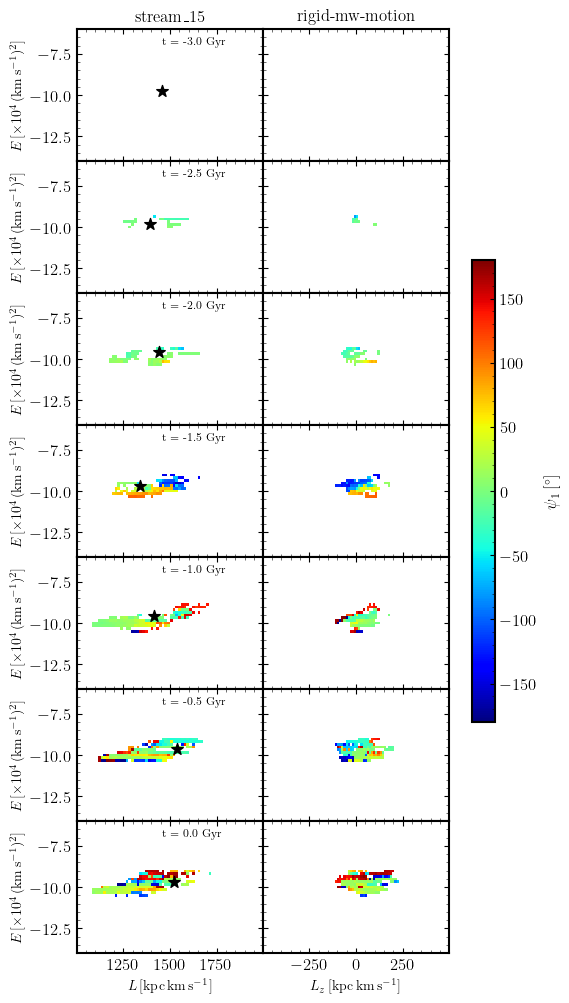

In [60]:
# data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/high-vel-dis/stream1/dt_halfmyr.hdf5" 
# data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/static-mw/stream_15.hdf5" 
data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/static-mw.hdf5" 

E_L_Lz_evol(data_path, 'stream_15', 'rigid-mw-motion', True)

<KeysViewHDF5 ['L', 'Lx', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'energies', 'lengths', 'lmc_sep', 'loc_veldis', 'pericenter', 'pole_b', 'pole_l', 'positions', 'potential', 'progenitor-ics', 'progenitor-mass', 'progenitor-scale', 'times', 'track_deform', 'velocities', 'widths']>
6.686796102397926 51.3675495041557


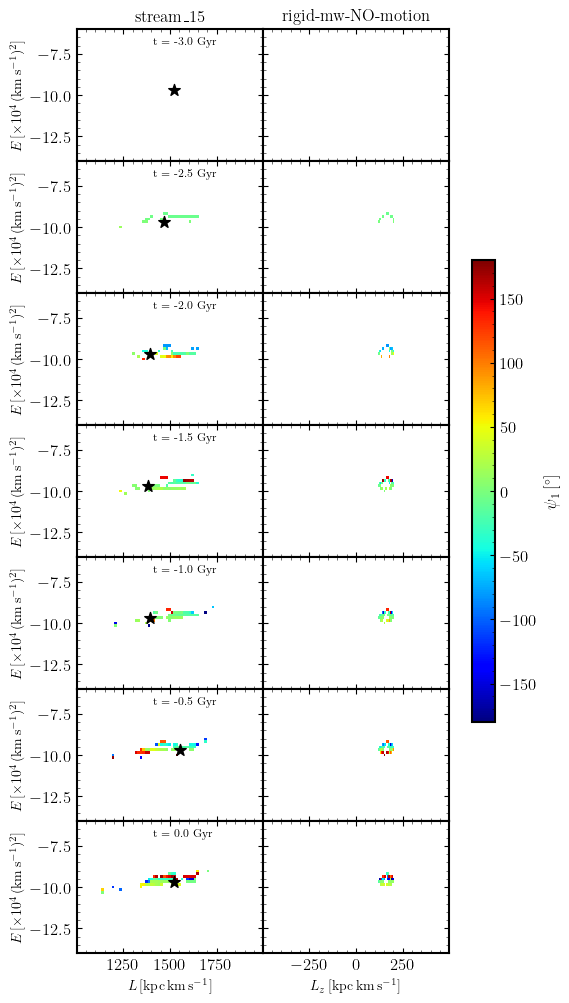

In [61]:
# data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/rigid-mw/stream_15.hdf5" 
data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/rigid-mw.hdf5" 

E_L_Lz_evol(data_path, 'stream_15', 'rigid-mw-NO-motion', True)

Energy - Angular momentum for all progenitors at different times

In [14]:
def E_L_Lz_evol_progentiors(path, Nstreams, plotname, savefig=False):

    Es =[]
    Ls=[]
    Lzs=[]
    pericenters=[]
    distances=[]
    xs = [] 
    vs = []
    
    for i in range(Nstreams):
        data_path = pathlib.Path(path) 
        with h5py.File(data_path,'r') as file:

            energies = np.array(file['stream_{}'.format(i)]["energies"])[:,0]
            ts = np.array(file['stream_{}'.format(i)]["times"])[2::2]
            prog_xs = np.array(file['stream_{}'.format(i)]["positions"])[:,0]
            prog_vs = np.array(file['stream_{}'.format(i)]["velocities"])[:,0]
            
            L = np.array(file['stream_{}'.format(i)]["L"])[:,0]
            Lz = np.array(file['stream_{}'.format(i)]["Lz"])[:,0]
            peris = np.array(file['stream_{}'.format(i)]["pericenter"])
            # dist = np.linalg.norm(np.array(file['stream_{}'.format(i)]["positions"])[:,0], axis=1)

            xs.append(prog_xs)
            vs.append(prog_vs)
            Es.append(energies)
            Ls.append(L)
            Lzs.append(Lz)
            pericenters.append(peris)
            # distances.append(dist)

            if i==(0):
                ts = np.array(file['stream_{}'.format(i)]["times"])[2::2]
                ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])
            
    # print(np.where( (np.array(Es)[:,-1] / 1e4) < -9) )

    time_mask = [0, 2, 4,  6, 8, 9, 10]
    ts_snaps_red = ts_snaps[time_mask]
    
    print(np.array(Es).shape)

    Ls_red = np.array(Ls)[:,time_mask]
    Lzs_red = np.array(Lzs)[:,time_mask]
    Es_red = np.array(Es)[:,time_mask]
    xs_red = np.array(xs)[:,time_mask]
    vs_red = np.array(vs)[:,time_mask]
    # distances_red = np.array(distances)[:,time_mask]

    fig, ax = plt.subplots(len(time_mask), 2, figsize=(4.5,8.5), sharey='row', sharex='col')
    plt.subplots_adjust(wspace=0., hspace=0)

    for i in range(len(ts_snaps_red)):
        
        # energies_red = energies_vec(ts_snaps[i], xs_red[:,i], vs_red[:,i],63,63,63, True)
        plt.sca(ax[i, 0])
        plt.scatter(Ls_red[:,i], Es_red[:,i]/1e4, c=pericenters, cmap='viridis', s=6, rasterized=True, vmin=5, vmax=25)
        plt.xlabel(r'$L\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=8)
        plt.ylabel(r'$E\,[\times 10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=7)
        # plt.annotate('t = {} Gyr'.format(np.round(ts_snaps_red[i],1)), xy=(5000,-8.5), fontsize=8, color='r')
        plt.text(0.75, 0.15, 't = {} Gyr'.format(np.round(ts_snaps_red[i],1)), 
                 horizontalalignment='center', verticalalignment='center', transform=ax[i,0].transAxes,
                fontsize=8)
        plt.xlim(np.nanmin(Ls_red[:,-1])*0.8, np.nanmax(Ls_red[:,-1])*1.2)
        plt.ylim(-14,-3)

        plt.sca(ax[i, 1])
        plt.scatter(Lzs_red[:,i], Es_red[:,i]/1e4, c=pericenters, cmap='viridis', s=6,  rasterized=True, vmin=5, vmax=25)
        plt.xlabel(r'$L_z\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=8)
        plt.xlim(np.nanmin(Lzs_red[:,-1])*1.25, np.nanmax(Lzs_red[:,-1])*1.25)

    plt.colorbar(ax=ax, label='Pericenter [kpc]', shrink=.5)
    # plt.colorbar(ax=ax, label='Distance [kpc]', shrink=.5)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/progenitors-E-L-Lz/{}'.format(plotname) )

(256, 11)


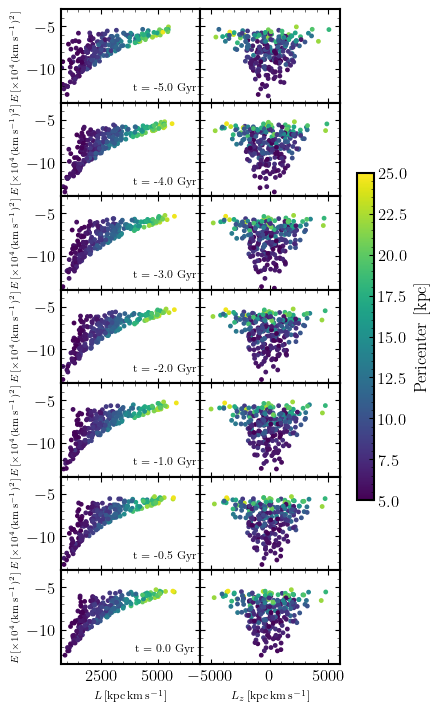

In [266]:
# path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-10rpmin-75ramax/Full-MWhalo-MWdisc-LMC.hdf5"
path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/static-mw.hdf5"

E_L_Lz_evol_progentiors(path, 256, 'rigidmw-motion-5rpmin-cperi', False)

Energy conservation of particle orbits

In [15]:
def gala_F(t, w, mwdflag, mwhflag, lmcflag, motion):
    t = t / 1e3  # Myr -> Gyr
    x0 = np.array(Model.expansion_centres(t))
    
    if motion==False:
        x0 *= 0 
    # disk
    acc_disk = Model.mwd_fields(t, *(w[:3, :] - x0[:3, None]), mwdharmonicflag=mwdflag)[:, :3]
    # halo
    acc_halo = Model.mwhalo_fields(t, *(w[:3] - x0[3:6, None]), mwhharmonicflag=mwhflag)[:, :3]
    # lmc
    acc_lmc = Model.lmc_fields(t, *(w[:3] - x0[6:9, None]), lmcharmonicflag=lmcflag)[:, :3]
    accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    accs = accs.decompose(galactic).value
    return np.vstack((w[3:], accs.T))


def gala_rewind(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag, motion):

    integrator = gi.LeapfrogIntegrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag, motion))
    # integrator = gi.DOPRI853Integrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag, motion))
    # integrator = gi.Ruth4Integrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag, motion))
    
    mwd_x0 = np.array(Model.expansion_centres(0.)[:3])*u.kpc 
    mwd_v0 = np.array(Model.expansion_centre_velocities(0.)[:3])*(u.km/u.s) 
    
    if motion==False:
        mwd_x0 *= 0
        mwd_v0 *= 0
    
    w0 = gd.PhaseSpacePosition(pos=w.xyz + mwd_x0,
                               vel=(w.v_xyz.to(u.km/u.s) + mwd_v0).to(u.kpc/u.Myr) )
    orbit = integrator.run(w0, dt=-dt*u.Myr, t1=Tend*u.Gyr, t2=Tbegin*u.Gyr)
    
    # subtract these off
    disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    
    if motion==False:
        disk_x0 *= 0
        disk_v0 *= 0
    
    pos=orbit.xyz - disk_x0.T*u.kpc,
    vel=orbit.v_xyz.to(u.km/u.s) - disk_v0.T*u.km/u.s,
    t=orbit.t
    return pos[0].to(u.kpc), vel[0].to(u.km/u.s), t.to(u.Gyr)

In [16]:
def energies_(t, xs, vs, mwdflag, mwhflag, lmcflag):
    """
    calculate the energies and angular momenta of particles for a given time snapshot.
    In the Galactocentric coordinate system. 
    xs,vs are already in GC coords.
    """
    # Kinetic energy
    Ek = (.5 * np.linalg.norm(vs, axis=0)**2) * (u.km/u.s)**2
    # Potential energy
    x0 = np.array(Model.expansion_centres(t))

    # if motion == False:
    #     x0 *= 0 
    
    x_lmc_GC = x0[6:9] - x0[:3]
            
    pot_disk = Model.mwd_fields(t,  xs[0], xs[1], xs[2], mwdflag)[4]
    pot_halo = Model.mwhalo_fields(t, xs[0], xs[1], xs[2], mwhflag)[4]
    pot_lmc = Model.lmc_fields(t, 
                               xs[0] - x_lmc_GC[0],
                               xs[1] - x_lmc_GC[1],
                               xs[2] - x_lmc_GC[2],
                               lmcflag)[4]
    Ep = (pot_disk + pot_halo + pot_lmc) * (u.km/u.s)**2
    E = Ek + Ep
    return E

def angmom_(t, xs, vs, mwdflag, mwhflag, lmcflag):
    """
    calculate the angular momenta of particles for a given time snapshot.
    """
    # Angular momentum
    L = np.linalg.norm(np.cross(xs, vs)) * (u.kpc*u.km/u.s)
    Lz = np.cross(xs[0:2], vs[0:2]) * (u.kpc*u.km/u.s)
    Lx = np.cross(xs[1:], vs[1:]) * (u.kpc*u.km/u.s)
    
    return L, Lz, Lx

In [17]:
def integrate_particle(params, motion):  
    
    inpath, snapname, outpath, filename, \
    fc, Mprog, a_s, pericenter, apocenter, Tbegin, Tfinal, dtmin, \
    mwhflag, mwdflag, lmcflag, strip_rate, \
    static_mwh, static_mwd, lmc_switch = params

    if static_mwh==True:
        _, MWHcoeffs = Model.return_mw_coefficients()
        MWHcoeffs = np.array(MWHcoeffs)
        MWHcoeffs[:,0] = MWHcoeffs[:,0][0] 
        MWHcoeffs[:,1:] = MWHcoeffs[:,1:]*0
        Model.install_mw_coefficients(MWHcoeffs)
        #Some line of code here to check they have been set to zero and reinstalled
        _, MWHcoeffs = Model.return_mw_coefficients()
        assert np.allclose(np.array(MWHcoeffs)[:,1:],0)==True, "MW halo coefficients need to be set to zero"
        
    if static_mwd==True:
        MWDfloats, MWDctmp, MWDstmp = Model.return_disc_coefficients()
        MWDctmp, MWDstmp = np.array(MWDctmp), np.array(MWDstmp)
        MWDctmp[:,0], MWDstmp[:,0] = MWDctmp[:,0][0], MWDstmp[:,0][0]
        MWDctmp[:,1:], MWDstmp[:,1:] = MWDctmp[:,1:]*0, MWDstmp[:,1:]*0
        Model.install_disc_coefficients(MWDctmp,MWDstmp)
        #Some line of code here to check they have been set to zero and reinstalled.
        MWDfloats, MWDctmp, MWDstmp = Model.return_disc_coefficients()
        assert np.allclose(np.array(MWDctmp)[:,1:],0)==True, "MW disc coefficients (c) need to be set to zero"
        assert np.allclose(np.array(MWDstmp)[:,1:],0)==True, "MW disc coefficients (s) need to be set to zero"
        
    if lmc_switch==True:
        _, LMCcoeffs = Model.return_lmc_coefficients()
        LMCcoeffs = np.array(LMCcoeffs)
        LMCcoeffs *= 0 
        Model.install_lmc_coefficients(LMCcoeffs)
        #Some line of code here to check they have been set to zero and reinstalled.
        _, LMCcoeffs = Model.return_lmc_coefficients()
        assert np.allclose(np.array(LMCcoeffs),0)==True, "LMC coefficients need to be set to zero"
    

    w0 = gd.PhaseSpacePosition.from_w(fc.T, units=galactic)
    print('rewinding progenitor... returns positions, velocities in Galactocentric coordinates')
    prog_orbit = gala_rewind(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w0, mwdflag, mwhflag, lmcflag, motion)
    rewind_xs = prog_orbit[0].T
    rewind_vs = prog_orbit[1].T 
    rewind_ts = prog_orbit[2].value

    print("calculating energies & angular momenta in Galactocentric coordinates...")
    Es = np.full(shape=(len(rewind_xs), 1), fill_value=np.nan)
    Ls = np.full(shape=(len(rewind_xs), 1), fill_value=np.nan)
    Lzs = np.full(shape=(len(rewind_xs), 1), fill_value=np.nan)
    Lxs = np.full(shape=(len(rewind_xs), 1), fill_value=np.nan)
    
    for i in range(len(rewind_xs)): #calculating in the inertial frame of reference
        Es[i] = energies_(rewind_ts[i], rewind_xs[i].value, rewind_vs[i].value, 
                                                       mwdflag, mwhflag, lmcflag)
        Ls[i], Lzs[i], Lxs[i] = angmom_(rewind_ts[i], rewind_xs[i].value, rewind_vs[i].value, 
                                                       mwdflag, mwhflag, lmcflag)   
        
    return rewind_xs, rewind_vs, rewind_ts, Es, Ls, Lzs, Lxs

In [18]:
def readparams(paramfile):
    """
    Read in the stream model parameters
    """
    with open(paramfile) as f:
        d = yaml.safe_load(f)

    inpath = d["inpath"]
    snapname = d["snapname"]
    outpath = d["outpath"]
    outname = d["outname"]
    prog_ics = np.array(d["prog_ics"])
    prog_mass = d["prog_mass"]
    prog_scale = d["prog_scale"] # kpc
    pericenter = d["pericenter"]
    apocenter = d["apocenter"]
    Tbegin = d["Tbegin"]
    Tfinal =  d["Tfinal"]
    dtmin  = 0.001 #d["dtmin"]
    haloflag = 0 #d["haloflag"]
    lmcflag = 0 #d["lmcflag"]
    discflag = 0 #d["discflag"]
    strip_rate = d["strip_rate"]
    # discframe = d["discframe"]
    static_mwh = True #d["static_mwh"]
    static_mwd = True #d["mwd_switch"]
    lmc_switch = True #d["lmc_switch"]

    assert type(inpath)==str, "inpath parameter  must be a string"
    assert type(snapname)==str, "snapname parameter must be a string"
    assert type(outpath)==str, "outpath parameter must be a string"
    assert type(outname)==str, "outname parameter must be a string"
    # assert type(prog_ics)==list, "prog_scale parameter must be a "
    assert type(prog_mass)==float, "prog_mass parameter must be a float"
    assert type(prog_scale)==float, "prog_scale parameter must be a float"
    assert type(Tbegin)==float, "Tbegin parameter must be an float"
    assert type(Tfinal)==float, "Tfinal parameter must be an float"
    assert type(dtmin)==float, "dtmin parameter must be an float"
    assert type(haloflag)==int, "haloflag parameter must be an int"
    assert type(lmcflag)==int, "lmcflag parameter must be an int"
    assert type(discflag)==int, "discflag parameter must be an int"
    assert type(strip_rate)==int, "strip_rate parameter must be an int"

    return [inpath, snapname, outpath, outname, prog_ics ,prog_mass, prog_scale, pericenter, apocenter, Tbegin, Tfinal, dtmin, 
            haloflag, discflag, lmcflag, strip_rate, static_mwh, static_mwd, lmc_switch]

In [20]:
file = "../ics/high-vel-dis/param_15.yaml"
# file = "../ics/rigid-mw/param_1021.yaml"
params = readparams(file)
params

['/mnt/home/rbrooks/ceph/oceanus/ics/high-vel-dis',
 'param_15',
 '/mnt/home/rbrooks/ceph/oceanus/analysis/stream-runs/high-vel-dis/stream15/',
 'dt_tenthmyr',
 array([-11.84223465,  -6.48417856,  -4.03090944,  -0.02671053,
         -0.02834739,  -0.12573716]),
 160370.78885522424,
 0.002,
 6.686796102397926,
 16.746852980473264,
 -5.0,
 0.0,
 0.001,
 0,
 0,
 0,
 2,
 True,
 True,
 True]

In [21]:
motion = False
rigid_xs, rigid_vs, rigid_ts, rigid_energies, rigid_Ls, rigid_Lzs, rigid_Lxs = integrate_particle(params, motion)

rewinding progenitor... returns positions, velocities in Galactocentric coordinates
calculating energies & angular momenta in Galactocentric coordinates...


In [22]:
motion = True
static_xs, static_vs, static_ts, static_energies, static_Ls, static_Lzs, static_Lxs = integrate_particle(params, motion)

rewinding progenitor... returns positions, velocities in Galactocentric coordinates
calculating energies & angular momenta in Galactocentric coordinates...


(-5.0, 0.0)

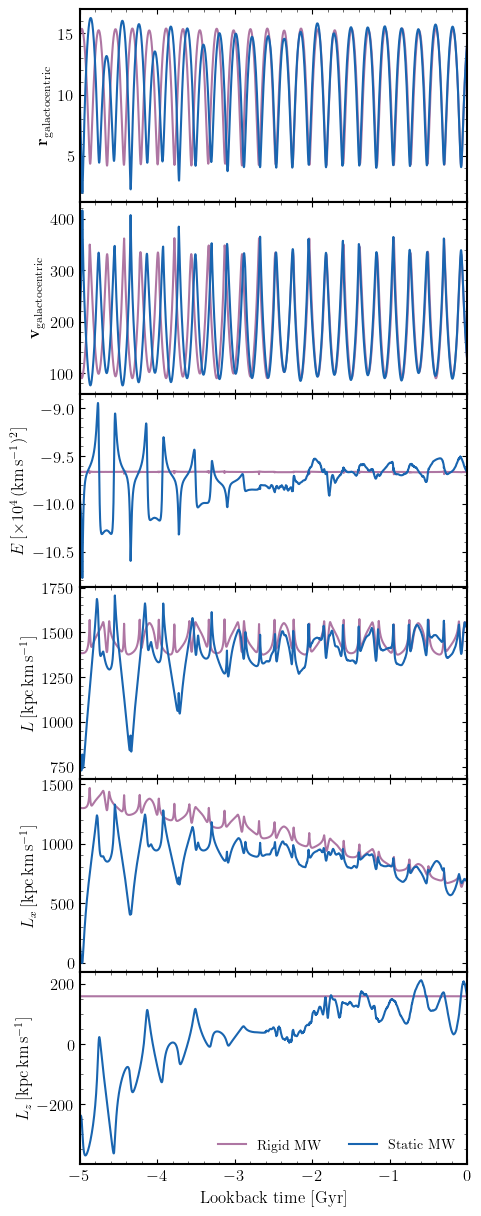

In [24]:
fig, ax  = plt.subplots(6,1, figsize=(5, 15), sharex=True)

plt.subplots_adjust(hspace=0)

plt.sca(ax[0])
plt.plot(rigid_ts, np.linalg.norm(rigid_xs, axis=1), label='Rigid MW')
plt.plot(static_ts, np.linalg.norm(static_xs, axis=1), label='Static MW')
# plt.plot(ts, [np.linalg.norm(Model.expansion_centres(t)[:3]) for t in ts], label='Disc')
# plt.ylim(0,)
plt.ylabel(r'$\mathbf{r}_{\mathrm{galactocentric}}$')

plt.sca(ax[1])
plt.plot(rigid_ts, np.linalg.norm(rigid_vs, axis=1))
plt.plot(static_ts, np.linalg.norm(static_vs, axis=1))
# plt.plot(ts, [np.linalg.norm(Model.expansion_centre_velocities(t)[:3]) for t in ts])
# plt.ylim(0,)
plt.ylabel(r'$\mathbf{v}_{\mathrm{galactocentric}}$')

plt.sca(ax[2])
plt.plot(rigid_ts, rigid_energies/1e4)
plt.plot(static_ts, static_energies/1e4)
# plt.ylim(-8,-4)
plt.ylabel(r'$E\,[\times 10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$')

plt.sca(ax[3])
plt.plot(rigid_ts, rigid_Ls)
plt.plot(static_ts, static_Ls)
plt.ylabel(r'$L\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$')

plt.sca(ax[4])
plt.plot(rigid_ts, rigid_Lxs)
plt.plot(static_ts, static_Lxs)
plt.ylabel(r'$L_x\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$')

plt.sca(ax[5])
plt.plot(rigid_ts, rigid_Lzs, label='Rigid MW')
plt.plot(static_ts, static_Lzs, label='Static MW')
plt.xlabel('Lookback time [Gyr]')
plt.ylabel(r'$L_z\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$')
plt.legend(frameon=False, fontsize=10, ncol=2)

plt.xlim(-5,0.)

# plt.savefig('../analysis/figures/high-vel-dis/rigid-vs-static-MW-orbit-normalstream.pdf')

Spread of energies, angular momentas with time

In [68]:
def spread_E_evol(data_path, stream, potentials, labels, plotname, savefig=False):

    fig, ax1 = plt.subplots(1,1, sharex='col', sharey='row', figsize=(5,3))
    
    i=0
    for p in potentials:
        
        path = data_path + '/' + p

        with h5py.File(path ,'r') as file:

            stream_file = file[stream]
            print(stream_file.keys())
            energies = np.array(stream_file['energies'])[:,1:]
            Ls = np.array(stream_file['L'])
            Lzs = np.array(stream_file['Lz'])

            ts =  np.array(stream_file["times"])[2::2]
            ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])
            
            stream_xs = np.array(stream_file["positions"])
            stream_vs = np.array(stream_file["velocities"])
            length = np.array(stream_file["lengths"])
        
#         sys_spread = []
#         for j in range(len(energies)):
                
#             lons, lats = lons_lats(stream_xs[j], stream_vs[j])
            
#             sigma_E = np.nanstd(energies[j])
#             offset_tails = np.nanmedian(energies[j][lons < 0]) - np.nanmedian(energies[j][lons > 0])
#             gradient = offset_tails / length
#             sys_spread.append(gradient * sigma_E)
        
        plt.sca(ax1)
        # plt.plot(ts_snaps, sys_spread, marker='o', markersize=3, label=labels[i] )
        plt.plot(ts_snaps, np.nanstd(energies, axis=1), marker='o', markersize=3, label=labels[i] )
        plt.xlabel(r'Lookback time [Gyr]')
        # plt.ylabel(r'$\sigma_{E} \times \nabla E_{\mathrm{stream}}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$')
        plt.ylabel(r'$\sigma_{E}[(\mathrm{km}\,\mathrm{s}^{-1})^2]$')
        plt.xlim(-3,0)
        plt.legend(frameon=False, fontsize=8)
        
        i += 1

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.sca(ax2)
    disc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[9:12]) for t in ts_snaps ])
    plt.ylabel(r'$\mathbf{r}_{\mathrm{disc}}\,[\mathrm{kpc}]$', color='grey')
    plt.tick_params(axis='y', labelcolor='grey')
    plt.plot(ts_snaps, disc_rs, color='grey', lw=1, alpha=.5)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/integrals-spreads/{}'.format(plotname + '-' + stream) )

In [83]:
def spread_L_evol(data_path, stream, potentials, labels, plotname, savefig=False):

    colors = ['#CC6677', '#332288']
    
    fig, ax1 = plt.subplots(1,1, sharex='col', sharey='row', figsize=(5,3))
    
    i=0
    for p in potentials:
        
        path = data_path + '/' + p
        
        color = colors[i]

        with h5py.File(path ,'r') as file:

            stream_file = file[stream]
            Ls = np.array(stream_file['L'])
            Lzs = np.array(stream_file['Lz'])

            ts =  np.array(stream_file["times"])[2::2]
            ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])
            
        plt.sca(ax1)
        # plt.plot(ts_snaps, np.nanstd(Ls, axis=1), marker='o', markersize=0, label=labels[i], c=color)
        plt.plot(ts_snaps, np.nanstd(Lzs, axis=1), marker='o', ls='solid',  markersize=3, c=color, label=labels[i])
        plt.xlabel(r'Lookback time [Gyr]')
        # plt.ylabel(r'$\sigma_{L_{i}}\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$')
        plt.ylabel(r'$\sigma_{L_{z}}\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$')
        plt.xlim(-3,0)
        plt.ylim(0, 99)
        plt.legend(frameon=False, fontsize=8)
        
        i += 1

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.sca(ax2)
    disc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[9:12]) for t in ts_snaps ])
    plt.ylabel(r'$\mathbf{r}_{\mathrm{disc}}\,[\mathrm{kpc}]$', color='grey')
    plt.tick_params(axis='y', labelcolor='grey')
    plt.plot(ts_snaps, disc_rs, color='grey', lw=1, alpha=.5)
    plt.ylim(0,)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/integrals-spreads/{}'.format(plotname + '-' + stream) )

Cannot select a time after the present day! Setting to present day...


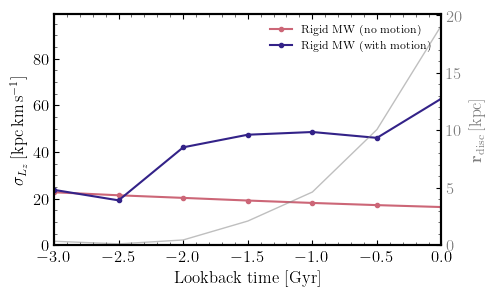

In [85]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/'
pots = ['rigid-mw.hdf5', 'static-mw.hdf5']
labels = ['Rigid MW (no motion)', 'Rigid MW (with motion)']
stream = 'stream_15'

# spread_E_evol(path, stream, pots, labels, 'spread_E_evol', True)
spread_L_evol(path, stream, pots, labels, 'spread_L_evol', False)

Adiabatic changes to disc motion?


In [224]:
def disc_vel_adiabatic(data_path, stream, plotname, savefig=False):

    fig, ax = plt.subplots(3,1, sharex='col', figsize=(5,6.5))
    plt.subplots_adjust(hspace=0.)

    with h5py.File(path ,'r') as file:

        stream_file = file[stream]
        ts =  np.array(stream_file["times"])[2::2]
        ts_plot = ts[::250]
        ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])

        stream_xs = np.array(stream_file["positions"]) * (u.kpc)
        stream_vs = np.array(stream_file["velocities"])* (u.km/u.s)

    orbit = gd.Orbit(stream_xs[:,0].T,
             stream_vs[:,0].to(u.kpc / u.Myr).T,
             t =ts_snaps, 
             frame=galactic )

    Torb = orbit.estimate_period(radial=True) * u.Gyr
    print(Torb)
    plt.sca(ax[0])
    plt.hlines(1 / Torb.to(u.Myr).value, -5, 0 , ls='dashed', label=r'$1 / T_{\mathrm{prog}} = \Omega_{\mathrm{prog}}/2\pi$')

    disc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[9:12]) for t in ts_plot ]) * (u.kpc)
    disc_vs = np.array([np.linalg.norm(Model.expansion_centre_velocities(t)[9:12]) for t in ts_plot ]) * (u.km/u.s)
    xdot_x_disc = (disc_vs.to(u.kpc / u.Myr)/disc_rs).value

    plt.plot(ts_plot, xdot_x_disc, lw=1, label='Disc', c='k')
    plt.ylabel(r'$\mathbf{\dot{x}_{\mathrm{disc}}}/\mathbf{x}_{\mathrm{disc}} \, [\mathrm{Myr}^{-1}]$')
    plt.legend(frameon=False, fontsize=10)
    plt.title(stream)
    
    plt.sca(ax[1])
    prog_vs = np.linalg.norm(stream_vs[:,0], axis=1)
    vperi_prog = np.nanmax(prog_vs)
    plt.plot(ts_plot, disc_vs/vperi_prog, lw=1, c='k')
    
    plt.ylabel(r'$\mathbf{v}_{\mathrm{disc}} / \mathbf{v}_{\mathrm{s,\,peri}}$')
   
    plt.ylim(0,.49)
    
    plt.sca(ax[2])
    plt.plot(ts_plot, disc_vs.to(u.kpc / u.Myr)*Torb.to(u.Myr).value, lw=1)
    plt.plot(ts_plot, disc_rs, lw=1, ls='dotted', c='Grey', label=r'$\mathbf{r}_{\mathrm{disc}}$')
    
    plt.xlabel(r'Lookback time [Gyr]')
    plt.ylabel(r'$\mathbf{v}_{\mathrm{disc}} \times T_{\mathrm{prog}} \, [\mathrm{kpc}] $')
    plt.legend(frameon=False, fontsize=10)
    
    plt.xlim(-5,0)
    plt.ylim(0.01,59)
        
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/{}'.format(plotname + '-' + stream) )

1.6250000000002647 Gyr
Cannot select a time after the present day! Setting to present day...
Cannot select a time after the present day! Setting to present day...


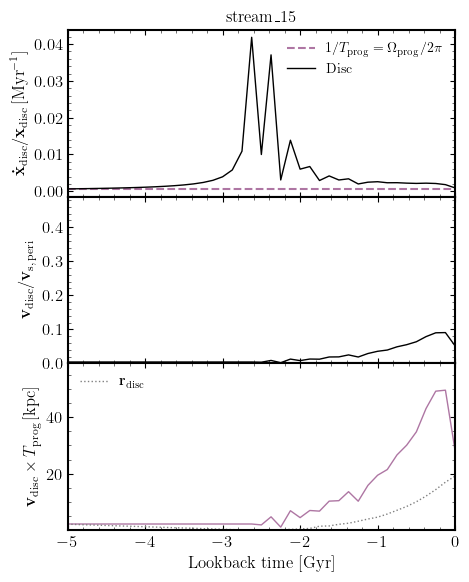

In [226]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/rigid-mw.hdf5'
# path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-10rpmin-75ramax/rigid-mw.hdf5'
stream = 'stream_15'

disc_vel_adiabatic(path, stream, 'orb-adiabaticity', True)

##### Pericenter vs velocity dispersion coloured by binding (potential) energy

<KeysViewHDF5 ['Eks', 'L', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'b_gc', 'ds', 'energies', 'l_gc', 'lats', 'lengths', 'lmc_sep', 'loc_veldis', 'lons', 'mass', 'pericenter', 'pm_b', 'pm_l_cosb', 'pole_b', 'pole_l', 'sigma_pole_b', 'sigma_pole_l', 'sigmavlos', 'track_deform', 'vlos', 'widths']>
-49866.8378318976 -140929.86295991455


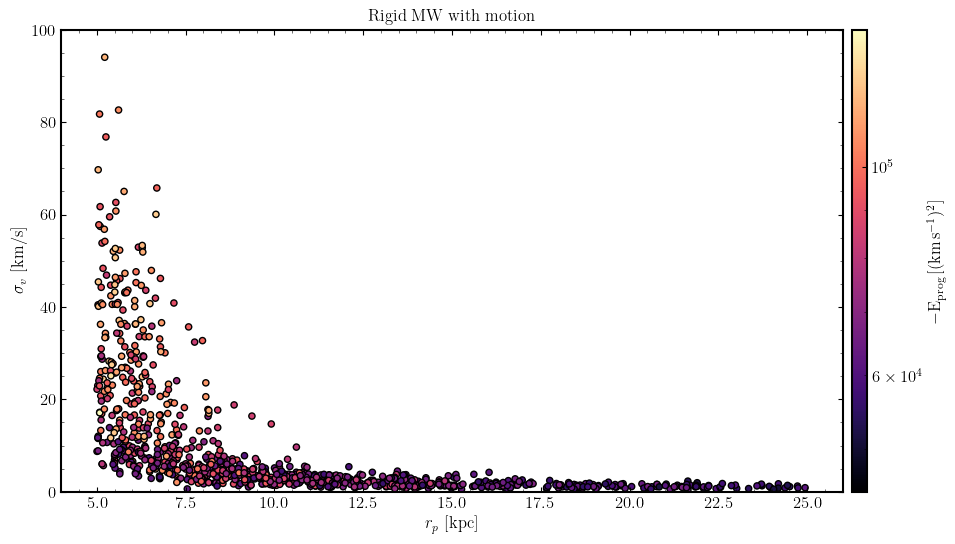

In [165]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-5kpcrpmin/static-mw.hdf5'
# path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/128-dt1Myr-5kpcrpmin/static-mw.hdf5'

with h5py.File(path ,'r') as file:
        print(file.keys())
        peris = np.array(file['pericenter'])
        apos = np.array(file['apocenter'])
        veldis = np.array(file['loc_veldis'])
        totalE  = np.array(file['energies'])
        # Eks  = np.array(file['Eks'])
        masses  = np.array(file['mass'])
        print(totalE.max(), totalE.min())


# Epot = totalE - Eks
fig, ax = plt.subplots(1,1, figsize=(12,6)) 
plot = plt.scatter(peris, veldis, c=-totalE, s=20,
               cmap='magma', edgecolor='k', rasterized=True, norm=LogNorm(vmin=1.4e5, vmax=5e4))
# plot = plt.scatter(peris, veldis, c=apos, s=25,
#                cmap='magma', edgecolor='k', rasterized=True)


plt.xlabel(r'$r_p$ [kpc]')
plt.ylabel(r'$\sigma_v$ [km/s]')
plt.xlim(4,26)
plt.ylim(0,100)
plt.title('Rigid MW with motion')

cb = fig.colorbar(plot, ax=ax,location='right', aspect=30, pad=0.01)
cb.set_label(r'$-\mathrm{E_{prog}} \, [(\mathrm{km}\,\mathrm{s}^{-1})^{2}]$')
# cb.set_label(r'$r_a \, [\mathrm{kpc}]$')
cb.ax.tick_params(labelsize=12)  

# plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/peri-veldis-apos')

In [100]:
cut1_veldis = veldis[ (peris < 10) & (veldis > 10)]
len(cut1_veldis)/len(veldis)

0.1640625

In [101]:
cut1_apos = apos[ (peris<10) & (veldis > 20)]
np.median(cut1_apos)

15.99959283154865

How does $\sigma_{v}$ vary as a function of $\phi_1$ over a stream?

In [92]:
def local_veldis(lons, vfs):
    # Compute percentiles
    lower_value = np.nanpercentile(lons, 5)
    upper_value = np.nanpercentile(lons, 95)
    # Filter lons_mainbody
    lons_mainbody = lons[(lons >= lower_value) & (lons <= upper_value)]
    vfs_mainbody = vfs[1:][(lons >= lower_value) & (lons <= upper_value)] #excludes progenitor [1:]
    # Create bins
    lon_bins = np.linspace(np.nanmin(lons_mainbody), np.nanmax(lons_mainbody), 50)
    # Compute absolute velocity norms
    vfs_absol = np.linalg.norm(vfs_mainbody, axis=1)
    # Slice lons_mainbody into bins
    bin_indices = np.digitize(lons_mainbody, lon_bins)
    # Create a mask array
    mask = np.zeros((len(lons_mainbody), len(lon_bins) - 1), dtype=bool)
    for i in range(1, len(lon_bins)):
        mask[:, i - 1] = (bin_indices == i)

    # Calculate standard deviation for each bin
    local_veldis = np.array([np.std(vfs_absol[m]) for m in mask.T])
    return lon_bins, local_veldis

In [111]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/static-mw.hdf5'
# path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/128-dt1Myr-5kpcrpmin/static-mw.hdf5'
stream = 'stream_0'

with h5py.File(path,'r') as file:
    print(file[stream].keys())
    ts = np.array(file[stream]["times"])[2::2]
    plot_ts = ts[::1000]
    prog_xs = np.array(file[stream]["positions"])[-6:-1]
    prog_vs = np.array(file[stream]["velocities"])[-6:-1]
    locveldis = np.array(file[stream]["loc_veldis"])
    peri = np.array(file[stream]["pericenter"])
    print(locveldis, peri)

<KeysViewHDF5 ['L', 'Lx', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'energies', 'lengths', 'lmc_sep', 'loc_veldis', 'pericenter', 'pole_b', 'pole_l', 'positions', 'potential', 'progenitor-ics', 'progenitor-mass', 'progenitor-scale', 'times', 'track_deform', 'velocities', 'widths']>
4.217935512656448 10.614394969204


In [109]:
lons_t0, lats_t0 = lons_lats(prog_xs[-1], prog_vs[-1])
lons_t1, lats_t1 = lons_lats(prog_xs[-2], prog_vs[-2])
lons_t2, lats_t2 = lons_lats(prog_xs[-3], prog_vs[-3])
lons_t3, lats_t3 = lons_lats(prog_xs[-5], prog_vs[-5])

IndexError: index -5 is out of bounds for axis 0 with size 4

In [110]:
lonbins_t0, veldis_bins_t0 = local_veldis(lons_t0, prog_vs[-1])
lonbins_t1, veldis_bins_t1 = local_veldis(lons_t1, prog_vs[-2])
lonbins_t2, veldis_bins_t2 = local_veldis(lons_t2, prog_vs[-3])
lonbins_t3, veldis_bins_t3 = local_veldis(lons_t3, prog_vs[-5])

lonbins_mid_t0 = [(lonbins_t0[i] + lonbins_t0[i+1]) / 2 for i in range(len(lonbins_t0) -1 )]
lonbins_mid_t1 = [(lonbins_t1[i] + lonbins_t1[i+1]) / 2 for i in range(len(lonbins_t1) -1 )]
lonbins_mid_t2 = [(lonbins_t2[i] + lonbins_t2[i+1]) / 2 for i in range(len(lonbins_t2) -1 )]
lonbins_mid_t3 = [(lonbins_t3[i] + lonbins_t3[i+1]) / 2 for i in range(len(lonbins_t3) -1 )]

TypeError: cannot unpack non-iterable numpy.float64 object

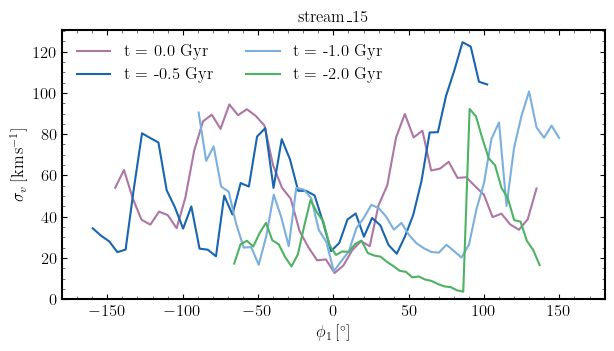

In [30]:
plt.figure(figsize=(7,3.5))
plt.plot(lonbins_mid_t0, veldis_bins_t0, label='t = {} Gyr'.format(np.round(plot_ts[-1], 2)))
plt.plot(lonbins_mid_t1, veldis_bins_t1, label='t = {} Gyr'.format(np.round(plot_ts[-2], 2)))
plt.plot(lonbins_mid_t2, veldis_bins_t2, label='t = {} Gyr'.format(np.round(plot_ts[-3], 2)))
plt.plot(lonbins_mid_t3, veldis_bins_t3, label='t = {} Gyr'.format(np.round(plot_ts[-5], 2)))

plt.xlabel(r'$\phi_1\,[^{\circ}]$')
plt.ylabel(r'$\sigma_v\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
plt.xlim(-180,180)
plt.ylim(0,)
plt.title(stream)
plt.legend(frameon=False, loc='upper left', ncol=2)
# plt.savefig('figures/high-vel-dis/sigma_v-across-streams/{}'.format(stream))

How does $\sigma_v$ vary with time?

In [87]:
def local_veldis(lons, vfs):
    # Compute percentiles
    lower_value = np.nanpercentile(lons, 5)
    upper_value = np.nanpercentile(lons, 95)
    # Filter lons_mainbody
    lons_mainbody = lons[(lons >= lower_value) & (lons <= upper_value)]
    vfs_mainbody = vfs[1:][(lons >= lower_value) & (lons <= upper_value)] #excludes progenitor [1:]
    # Create bins
    lon_bins = np.linspace(np.nanmin(lons_mainbody), np.nanmax(lons_mainbody), 50)
    # Compute absolute velocity norms
    vfs_absol = np.linalg.norm(vfs_mainbody, axis=1)
    # Slice lons_mainbody into bins
    bin_indices = np.digitize(lons_mainbody, lon_bins)
    # Create a mask array
    mask = np.zeros((len(lons_mainbody), len(lon_bins) - 1), dtype=bool)
    for i in range(1, len(lon_bins)):
        mask[:, i - 1] = (bin_indices == i)

    # Calculate standard deviation for each bin
    local_veldis = np.array([np.std(vfs_absol[m]) for m in mask.T])
    return np.nanmedian(local_veldis)


def spread_veldis_evol(data_path, stream, potentials, labels, plotname, savefig=False):

    fig, ax1 = plt.subplots(1,1, sharex='col', sharey='row', figsize=(5,3))
    
    i=0
    for p in potentials:
        
        path = data_path + '/' + p

        with h5py.File(path ,'r') as file:

            stream_file = file[stream]

            ts =  np.array(stream_file["times"])[2::2]
            ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])
            
            stream_xs = np.array(stream_file["positions"])
            stream_vs = np.array(stream_file["velocities"])
            length = np.array(stream_file["lengths"])
        
        lonslats = np.array([lons_lats(stream_xs[j], stream_vs[j]) for j in range(len(stream_xs))])
        lons, lats = lonslats[:,0], lonslats[:,1]
        veldis_ts = [local_veldis(lons[j], stream_vs[j]) for j in range(1,len(stream_vs))]
        plt.sca(ax1)
        # plt.plot(ts_snaps, sys_spread, marker='o', markersize=3, label=labels[i] )
        plt.plot(ts_snaps[1:], veldis_ts, marker='o', markersize=3, label=labels[i] )
        plt.xlabel(r'Lookback time [Gyr]')
        # plt.ylabel(r'$\sigma_{E} \times \nabla E_{\mathrm{stream}}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$')
        plt.ylabel(r'$\sigma_{v}[\mathrm{km}\,\mathrm{s}^{-1}]$')
        plt.xlim(-3,0)
        plt.legend(frameon=False, fontsize=10)
        plt.title(stream)
        
        i += 1

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.sca(ax2)
    disc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[9:12]) for t in ts_snaps ])
    plt.ylabel(r'$\mathbf{r}_{\mathrm{disc}}\,[\mathrm{kpc}]$', color='grey')
    plt.tick_params(axis='y', labelcolor='grey')
    plt.plot(ts_snaps, disc_rs, color='grey', lw=1, alpha=.5)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/integrals-spreads/{}'.format(plotname + '-' + stream) )

Cannot select a time after the present day! Setting to present day...


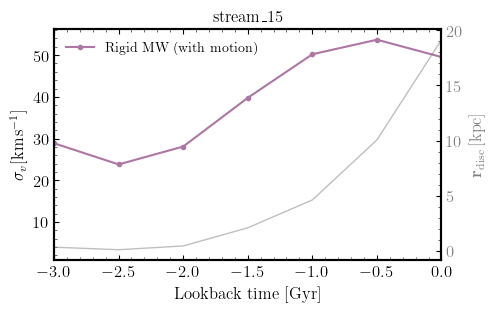

In [88]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/'
pots = ['static-mw.hdf5']
labels = ['Rigid MW (with motion)']
stream = 'stream_15'

spread_veldis_evol(path, stream, pots, labels, 'spread_veldis_evol', True)

Is there a preferred direction/orientation w.r.t to disc's reflex motion that has higher velocity streams?

In [38]:
def galactic_coords(p, v):
    
    galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
    galcen_distance = 8.249*u.kpc
    
    posvel_gc = SkyCoord(x=p[:,0]*u.kpc, y=p[:,1]*u.kpc, z=p[:,2]*u.kpc,
                         v_x=v[:,0]*u.km/u.s, v_y=v[:,1]*u.km/u.s, v_z=v[:,2]*u.km/u.s ,
                         frame='galactocentric', galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)
    posvel_galactic = posvel_gc.transform_to('galactic')
    posvel_galactic_rc = gc.reflex_correct(posvel_galactic)
    l, b, d = posvel_galactic_rc.l, posvel_galactic_rc.b, posvel_galactic_rc.distance
    pm_l_cosb, pm_b, rvs = posvel_galactic_rc.pm_l_cosb, posvel_galactic_rc.pm_b, posvel_galactic_rc.radial_velocity
    
    return l.value, b.value, d.value, pm_l_cosb.value, pm_b.value, rvs.value,

def mollewide_gc(path_data, pots, pot_labels, plotname, savefig=False):

    pltidx = [0, 1]
    
    fig, ax = plt.subplots(2, 1, subplot_kw={'projection': 'mollweide'}, figsize=(10, 10))
    
    plt.subplots_adjust(hspace=-0.1, wspace=0.1)

    for j in range(len(pots)): 

        with h5py.File(path_data + potentials[j],'r') as file:
            
            t_idx = -1

            l_gc = np.array(file['l_gc'])
            b_gc = np.array(file['b_gc'])
            loc_veldis = np.array(file['loc_veldis'])

        wrapped_ls = -np.where(l_gc>=180, l_gc - 360, l_gc)
        
        plt.sca(ax[pltidx[j]])
        ax[pltidx[j]].tick_params(labelsize=8)
        plt.grid(alpha=.25)
        
        ts=np.linspace(-2.5, 0, 100)
        disc_xs = [Model.expansion_centres(t)[:3] for t in ts]
        disc_vs =  [Model.expansion_centre_velocities(t)[:3] for t in ts]
        disc_l_gc, disc_b_gc, *_ = galactic_coords(np.array(disc_xs), np.array(disc_vs))
        
        sc=plt.scatter(wrapped_ls*u.deg.to(u.rad), b_gc*u.deg.to(u.rad), 
                       c=loc_veldis, cmap='rainbow',edgecolor='k', s=20,rasterized=True, vmin=0,vmax=100,zorder=2)
        if j==1:
            cb=plt.colorbar(sc, ax=[ax[i] for i in pltidx], location='right', aspect=40, pad=0.05, shrink=.5)
            cb.ax.tick_params(labelsize=14)
            cb.set_label(r'$\sigma_{v, \mathrm{loc}}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')

        disc_l_gc_wrap = -np.where(disc_l_gc >= 180, disc_l_gc - 360, disc_l_gc)
        
        print(np.nanmin(disc_b_gc), np.nanmax(disc_b_gc))

        plt.scatter(disc_l_gc_wrap[-1]*u.deg.to(u.rad), disc_b_gc[-1]*u.deg.to(u.rad), s=150,  zorder=3,
                            edgecolors='k', facecolor='lightgrey',marker='o', label='Disc - present day', rasterized=True)
  
        plt.scatter((disc_l_gc_wrap) * u.deg.to(u.rad), disc_b_gc * u.deg.to(u.rad), rasterized=True, 
                     s=5,c='grey', zorder=2)

        plt.title(labels[j], loc='left', fontsize=12)
        if j ==0:
            plt.legend(frameon=False, fontsize=10, loc='upper right')
    
    for axs in ax.flat:
        x_labels = axs.get_xticks() * 180/np.pi
        axs.set_xticklabels(['{:.0f}'.format(-label) + r'$^{\circ}$' for label in x_labels])

    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/{}'.format(plotname))
    # plt.close()

-2.333983017708498 0.025054723349315244
-2.333983017708498 0.025054723349315244


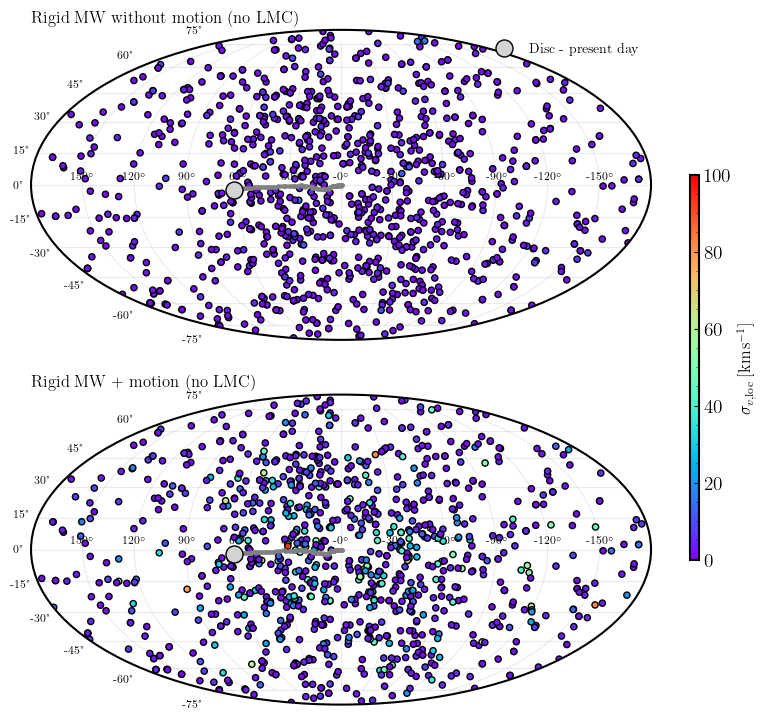

In [39]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-5kpcrpmin/'

potentials = list(['static-mwh-only.hdf5','static-mw.hdf5'])

labels = list(['Rigid MW without motion (no LMC)','Rigid MW + motion (no LMC)'])

mollewide_gc(path, potentials, labels, 'gc-veldis-disc-motion', False)

Are the inner halo streams on prograde or retrograde orbits?

In [473]:
def pole_hist(path, plotname, savefig=False):
    
    potentials = list(['static-mw.hdf5'])
    title = 'Rigid MW + motion (no LMC)'
    fig, ax = plt.subplots(1,1, figsize=(5,2.5))
    plt.sca(ax)

    for j in range(len(potentials)):    
        data_path = pathlib.Path(path) / potentials[j]
    
        with h5py.File(data_path,'r') as file:
            pole_bs = np.array(file['pole_b'])[:,-1][:,0]
            peris = np.array(file['pericenter'])
            
        peri_mask = (peris < 10)
            
        sinb = np.sin((pole_bs*u.deg).to(u.rad)).value
        sinb_innerstreams = sinb[peri_mask]
        sinb_outerstreams = sinb[~peri_mask]
    
        plt.hist(sinb, bins=np.linspace(-1,1,15), histtype='step', fill=False, label='All streams', density=True)
        plt.hist(sinb_innerstreams, bins=np.linspace(-1,1,15), histtype='step', fill=False, label=r'$r_p < 10 \,\mathrm{kpc}$', density=True)
        plt.hist(sinb_outerstreams, bins=np.linspace(-1,1,15), histtype='step', fill=False, label=r'$r_p > 10 \,\mathrm{kpc}$', density=True)

    plt.xlabel('$\sin(b_{\mathrm{pole}})$')
    plt.ylabel('N')
    plt.ylim(0,1)
    plt.legend(frameon=False, fontsize=10)
    plt.title(title)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/{}'.format(plotname))
    # plt.close()

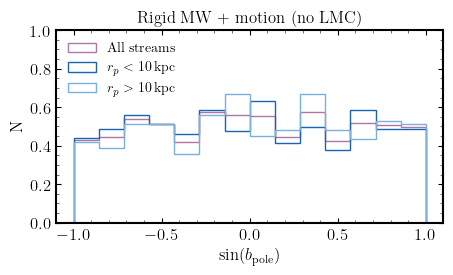

In [475]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-5kpcrpmin/'
pole_hist(path, 'sinb-pole-hist', False)

Orbital properties of inner halo streams

In [5]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-5kpcrpmin/Full-MWhalo-MWdisc-LMC.hdf5'
# path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/rigid-mw.hdf5'
with h5py.File(path,'r') as file:
    print(file.keys())
    pericenters = np.array(file['pericenter'])
    apocenters = np.array(file['apocenter'])
    rgal = np.array(file['ds'])

    # pms = np.array(file['pm_misalignment'])
    veldis = np.array(file['loc_veldis'])
    l_gc, b_gc = np.array(file['l_gc']), np.array(file['b_gc'])


f = (rgal - pericenters) / (apocenters - pericenters)

e = (apocenters - pericenters) / (apocenters + pericenters)

<KeysViewHDF5 ['L', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'b_gc', 'ds', 'energies', 'l_gc', 'lats', 'lengths', 'lmc_sep', 'loc_veldis', 'lons', 'mass', 'pericenter', 'pm_b', 'pm_l_cosb', 'pole_b', 'pole_l', 'sigma_pole_b', 'sigma_pole_l', 'sigmavlos', 'track_deform', 'vlos', 'widths']>


In [6]:
galactocentric_xs = SkyCoord(l=l_gc*u.deg, b=b_gc*u.deg,
                            distance=rgal*u.kpc, frame='galactic',
                            galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s,
                            galcen_distance = 8.249*u.kpc).transform_to('galactocentric')

galcen_xs = np.array([galactocentric_xs.x.value, galactocentric_xs.y.value, galactocentric_xs.z.value]).T
galcen_rs = np.linalg.norm(galcen_xs, axis=1)

disc_xs_t0 = Model.expansion_centres(0)[9:]
disc_rs_t0 = np.linalg.norm(Model.expansion_centres(0)[9:])

rsep_disc_stream_t0 = np.abs(galcen_rs - disc_rs_t0)

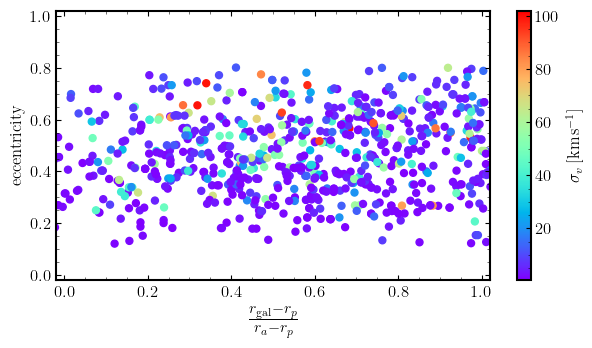

In [7]:
plt.figure(figsize=(7,3.5))
plt.scatter(f, e, c=veldis, cmap='rainbow')
plt.xlim(-0.02,1.02)
plt.ylim(-0.02,1.02)

plt.xlabel(r'$\frac{r_{\mathrm{gal}} - r_p}{r_a - r_p}$', fontsize=16)
plt.ylabel('eccentricity')

cbar=plt.colorbar()
# cbar.set_label(r'$r_a\,[\mathrm{kpc}]$')
cbar.set_label('$\sigma_v\,[\mathrm{km}\,\mathrm{s}^{-1}]$')


# plt.savefig('figures/misc/orbphase-ecc-cbar-pms')

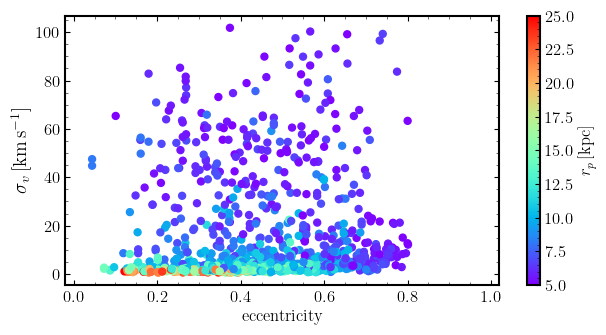

In [8]:
plt.figure(figsize=(7,3.5))
plt.scatter(e, veldis, c=pericenters, cmap='rainbow', vmin=5, vmax=25)
plt.xlim(-0.02,1.02)

plt.ylabel(r'$\sigma_v\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)
plt.xlabel('eccentricity')

cbar=plt.colorbar()
cbar.set_label(r'$r_p\,[\mathrm{kpc}]$')
# plt.savefig('figures/high-vel-dis/ecc-veldis-cbar-peri')

In [ ]:
plt.figure(figsize=(7,3.5))
plt.scatter(pericenters, veldis, c=e, cmap='rainbow', vmin=0.01, vmax=0.9 )

plt.ylabel(r'$\sigma_v\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)
plt.xlabel('$r_p\,[\mathrm{kpc}]$')

cbar=plt.colorbar()
# cbar.set_label(r'$r_a\,[\mathrm{kpc}]$')
cbar.set_label('eccentricity')

plt.ylim(-2,200)
plt.xlim(0,)

(0.0, 25.94011923934745)

In [121]:
np.where( (pericenters < 6 ) & (veldis > 20) & (veldis < 40) )

(array([ 21,  40,  42,  64,  73,  85,  92, 104, 122, 155, 188, 191, 215,
        239, 266, 272, 321, 350, 375, 391, 397, 426, 477, 492, 494, 508,
        519, 520, 557, 598, 633, 640, 663, 675, 678, 698, 705, 716, 718,
        739, 751, 758, 760, 775, 843, 845, 867, 871, 893, 940, 943, 971,
        995]),)

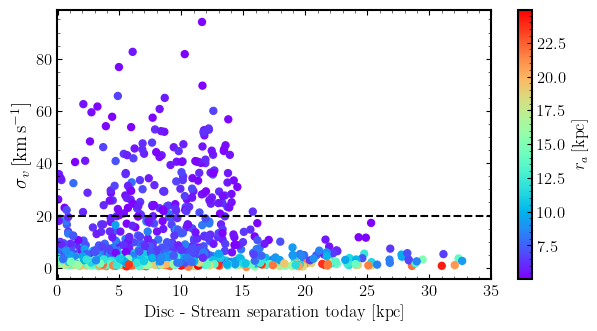

In [9]:
plt.figure(figsize=(7,3.5))
plt.scatter(rsep_disc_stream_t0, veldis, c=pericenters, cmap='rainbow')
plt.xlim(-0.02,35)

plt.xlabel('Disc - Stream separation today [kpc]')
plt.ylabel(r'$\sigma_v\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)

plt.hlines(20, -1, 40, color='k', ls='dashed')

cbar=plt.colorbar()
cbar.set_label(r'$r_a\,[\mathrm{kpc}]$')


# plt.savefig('figures/high-vel-dis/rsepdiscstream-veldis-cbar-peri')

In [10]:
np.where( (rsep_disc_stream_t0 > 5 ) & (rsep_disc_stream_t0 < 10) & (veldis > 20.7) & (veldis < 20.9))

(array([272]),)

In [122]:
with h5py.File('../analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/static-mw.hdf5','r') as file:
    stream = file['stream_40']
    print(stream.keys())
    xs = np.array(stream['positions'])
    vs = np.array(stream['velocities'])
    ts = np.array(stream['times'])
    sigmav = np.array(stream['loc_veldis'])
    print(sigmav)

<KeysViewHDF5 ['L', 'Lx', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'energies', 'lengths', 'lmc_sep', 'loc_veldis', 'pericenter', 'pole_b', 'pole_l', 'positions', 'potential', 'progenitor-ics', 'progenitor-mass', 'progenitor-scale', 'times', 'track_deform', 'velocities', 'widths']>
26.11179960550111


In [123]:
galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

posvel_gc = SkyCoord(x=xs[-1][:,0]*u.kpc, y=xs[-1][:,1]*u.kpc, z=xs[-1][:,2]*u.kpc,
                     v_x=vs[-1][:,0]*u.km/u.s, v_y=vs[-1][:,1]*u.km/u.s, v_z=vs[-1][:,2]*u.km/u.s ,
                     frame='galactocentric', galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)
posvel_galactic = posvel_gc.transform_to('galactic')
posvel_galactic_rc = gc.reflex_correct(posvel_galactic)
l, b, d = posvel_galactic_rc.l, posvel_galactic_rc.b,posvel_galactic_rc.distance
pm_l_cosb, pm_b, rvs = posvel_galactic_rc.pm_l_cosb, posvel_galactic_rc.pm_b, posvel_galactic_rc.radial_velocity

# sigma_rv = np.nanstd(posvel_galactic_rc.radial_velocity)

In [124]:
lons, lats = lons_lats(xs[-1], vs[-1])

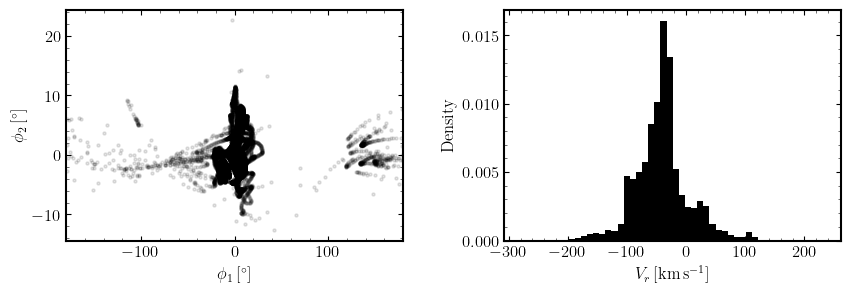

In [125]:
fig, ax  = plt.subplots(1, 2, figsize=(10,3))

plt.subplots_adjust(wspace=.3)

plt.sca(ax[0])
plt.scatter(lons, lats, c='k', alpha=.1, s=5)
plt.xlabel(r'$\phi_1\,[^{\circ}]$')
plt.ylabel(r'$\phi_2\,[^{\circ}]$')
plt.xlim(-180,180)
# plt.ylim(-49,49)

plt.sca(ax[1])
plt.hist(rvs.value, bins=50, density=True, color='k')
plt.xlabel(r'$V_r\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
plt.ylabel('Density')

# plt.savefig('figures/high-vel-dis/stream_42-wrapphi1-Vrdist')
plt.show()

Movie of an inner halo stream

In [153]:
with h5py.File('../analysis/stream-runs/high-vel-dis/stream1/dt_1myr.hdf5','r') as file:
    print(file.keys())

    xs = np.array(file['positions'])
    vs = np.array(file['velocities'])
    ts = np.array(file['times'])

    print(np.array(file['potential']))

<KeysViewHDF5 ['L', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'energies', 'lengths', 'lmc_sep', 'loc_veldis', 'pericenter', 'pole_b', 'pole_l', 'positions', 'potential', 'progenitor-ics', 'progenitor-mass', 'progenitor-scale', 'times', 'track_deform', 'velocities', 'widths']>
b'Full-MWhalo-MWdisc-LMC'


In [93]:
with h5py.File('../analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/static-mw.hdf5','r') as file:
    stream = file['stream_15']

    xs = np.array(stream['positions'])
    vs = np.array(stream['velocities'])
    ts = np.array(stream['times'])

    print(np.array(stream['loc_veldis']))

65.74263982017888


In [94]:
ts_snaps = np.flip(np.flip(ts, axis=0)[::2000])

In [95]:
ts_snaps

array([-4.9995e+00, -4.4995e+00, -3.9995e+00, -3.4995e+00, -2.9995e+00,
       -2.4995e+00, -1.9995e+00, -1.4995e+00, -9.9950e-01, -4.9950e-01,
        5.0000e-04])

In [96]:
xs_disc = np.array([Model.expansion_centres(t)[9:12] for t in ts_snaps])

Cannot select a time after the present day! Setting to present day...


In [97]:
progxs = xs[:,0]

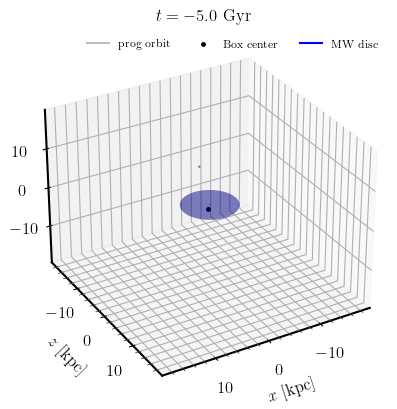

In [98]:
import matplotlib.animation as animation
import matplotlib.patches as patches

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.clear()

    ax.set_xlim(-19,19)
    ax.set_ylim(-19,19)
    ax.set_zlim(-19,19)
    ax.set_xlabel(r'$x$ [kpc]')
    ax.set_ylabel(r'$y$ [kpc]')
    ax.set_ylabel(r'$z$ [kpc]')
    
    ax.plot(progxs[::50][:frame+1][:, 0], 
               progxs[::50][:frame+1][:, 1], 
               progxs[::50][:frame+1][:, 2], color='k', alpha=.25, label='prog orbit')
    ax.scatter(xs[frame][:, 0], 
               xs[frame][:, 1], 
               xs[frame][:, 2], 
               marker='.', c='grey', s=1, rasterized=True)
    ax.scatter(0, 0, 0, s=25, edgecolors='k', facecolor='k', marker='.', label='Box center')


    xlim = ax.get_xlim()    
    fig_width_inch, _ = fig.get_size_inches()
    ax_kpc = xlim[1] - xlim[0]
    
    # Convert kpc to inches for marker size
    marker_size_inch = (5 / ax_kpc) * fig_width_inch
    # Convert marker size in inches to points^2 (Matplotlib marker size units)
    marker_size_pts2 = (marker_size_inch * 72) ** 2

    # Set the center and radius of the disc
    # Parameters for the disc
    center = (xs_disc[:,0][frame], xs_disc[:,1][frame], xs_disc[:,2][frame])  # Center of the disc (x, y, z)
    radius = 5  # Radius of the disc
    normal_vector = (0, 0, 1)  # Normal vector of the disc (aligned with z-axis)
    
    # Generate a grid of points in polar coordinates
    theta = np.linspace(0, 2 * np.pi, 100)
    r = np.linspace(0, radius, 50)
    theta, r = np.meshgrid(theta, r)
    
    # Convert polar coordinates to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.zeros_like(x)  # Disc lies in the XY plane, so z is constant
    
    # Translate the disc to the desired center
    x += center[0]
    y += center[1]
    z += center[2]
    
    # Plot the surface of the disc
    ax.plot_surface(x, y, z, color='blue', alpha=0.6)
  
    ax.plot(xs_disc[:,0][:frame+1], 
            xs_disc[:,1][:frame+1], 
            xs_disc[:,2][:frame+1], color='b', label='MW disc')
    # ax.scatter(xs_disc[:,0][frame], 
    #            xs_disc[:,1][frame], 
    #            xs_disc[:,2][frame], s=marker_size_pts2, edgecolors='k', facecolor='b', marker='o')


    ax.view_init(azim = 60, elev = 30) #azim,: -60, 60

    ax.legend(frameon=False, ncol=3, fontsize=8)
    ax.set_title(r'$t = {}$ Gyr'.format(np.round(ts_snaps[frame], 2)))

ani = animation.FuncAnimation(fig, update, frames=len(ts_snaps) -1 , interval=5000)


writer = animation.PillowWriter(fps=1)
ani.save('movies/high-vel-dis/stream15.gif', writer=writer)

In [79]:
with h5py.File('../analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/rigid-mw.hdf5','r') as file:
    stream = file['stream_272']
    print(stream.keys())
    print(np.array(stream["pericenter"]), np.array(stream["apocenter"]), np.array(stream["potential"]))

    xs_rigid = np.array(stream['positions'])
    vs_rigid = np.array(stream['velocities'])

<KeysViewHDF5 ['L', 'Lx', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'energies', 'lengths', 'lmc_sep', 'loc_veldis', 'pericenter', 'pole_b', 'pole_l', 'positions', 'potential', 'progenitor-ics', 'progenitor-mass', 'progenitor-scale', 'times', 'track_deform', 'velocities', 'widths']>
5.372568009851432 17.157282783177138 b'rigid-mw'


In [80]:
with h5py.File('../analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/rm-MWhalo-full-MWdisc-full-LMC.hdf5','r') as file:
    stream = file['stream_272']

    xs_rigid_moving = np.array(stream['positions'])
    v_rigid_moving = np.array(stream['velocities'])


Text(0, 0.5, 'z [kpc]')

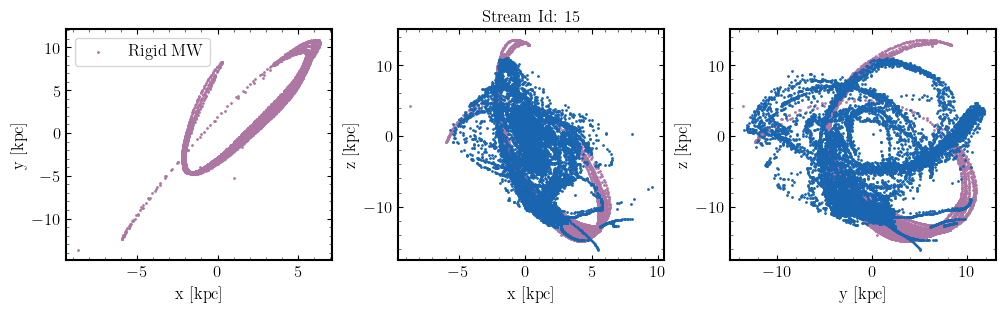

In [82]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

plt.subplots_adjust(wspace=0.25)

plt.sca(ax[0])
plt.scatter(xs_rigid[-1][:,0], xs_rigid[-1][:,1], s=1, label='Rigid MW', rasterized=True)
# plt.scatter(xs_rigid_moving[-1][:,0], xs_rigid_moving[-1][:,1], s=1, label='Rigid + motion + LMC', rasterized=True)
plt.legend()

plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')

plt.sca(ax[1])
plt.scatter(xs_rigid[-1][:,0], xs_rigid[-1][:,2], s=1, rasterized=True)
plt.scatter(xs_rigid_moving[-1][:,0], xs_rigid_moving[-1][:,2], s=1, rasterized=True)

plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.title('Stream Id: 15')

plt.sca(ax[2])
plt.scatter(xs_rigid[-1][:,1], xs_rigid[-1][:,2], s=1, rasterized=True)
plt.scatter(xs_rigid_moving[-1][:,1], xs_rigid_moving[-1][:,2], s=1, rasterized=True)

plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')

# plt.savefig('figures/high-vel-dis/stream15-2d-cartesian')

Text(0.5, 0.92, 'Stream Id: 15')

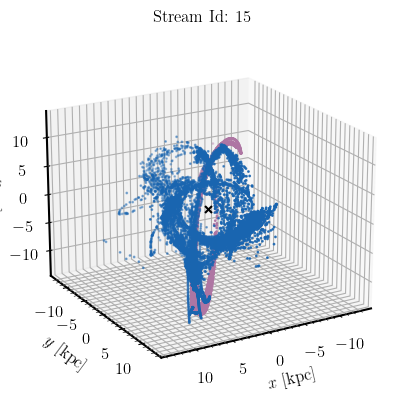

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs_rigid[-1][:,0], xs_rigid[-1][:,1], xs_rigid[-1][:,2], 'o', s=1, rasterized=True)
ax.scatter(xs_rigid_moving[-1][:,0], xs_rigid_moving[-1][:,1], xs_rigid_moving[-1][:,2], 'o', s=1, label='MW1-NoLMC', rasterized=True)

ax.scatter(0,0,0, s=25, marker='x',color='k')

# plt.legend(frameon=True, ncol=1, fontsize=9, loc='upper right')

ax.view_init(azim = 60, elev =20)

ax.set_xlim(-14,14)
ax.set_ylim(-14,14)
ax.set_zlim(-14,14)
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
ax.set_zlabel(r'$z$ [kpc]')

plt.title('Stream Id: 15')

# plt.savefig('figures/high-vel-dis/stream15-3d-cartesian')